In [1]:
from typing import Tuple, Iterable, List
from pprint import pformat
import random
import pickle
import os
from pathlib import Path
from collections import defaultdict

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from tqdm import tqdm

/home/adeel/anaconda3/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
from pyproj import Geod, CRS
from shapely.geometry import Point, LineString

In [4]:
import osmnx as ox
import networkx as nx
from networkx.classes.function import path_weight
import gc
ox.config(use_cache=True, log_console=True)

/home/adeel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/adeel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar'

In [5]:
from itertools import product
from functools import lru_cache

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.reset_defaults()

plt.style.use("default")
# plt.style.use("dark_background")

In [7]:
import geojson
import json
from shapely.geometry import mapping
from shapely.geometry.multilinestring import MultiLineString

In [8]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [9]:
GEOD = CRS.from_epsg(4326).get_geod()

In [12]:
# COUNTRY = 'Guatemala'
COUNTRY = 'Paraguay'

root_dirs = {
    'Guatemala': Path('/home/adeel/2021 - RAI Toolkit-20210528T125906Z-001/2021 - RAI Toolkit/Country Data/Guatemala_4-19-2021'),
    'Paraguay': Path('/home/adeel/2021 - RAI Toolkit-20210528T125906Z-001/2021 - RAI Toolkit/Country Data/Paraguay'),
}

file_paths = {
    'geonames': {
        'Guatemala': Path('GT/GT.txt'),
        'Paraguay': Path('PY/PY.txt'),
    },
    'wb_data': {
        'Guatemala': Path('simple_cases.csv'),
        'Paraguay': Path('simple_cases.csv'),
    },
    'graph': {
        'Guatemala': Path('graph.graphml'),
        'Paraguay': Path('graph.graphml'),
    },
}

os.chdir(root_dirs[COUNTRY])

In [13]:
os.path.realpath(os.curdir)

'/home/adeel/2021 - RAI Toolkit-20210528T125906Z-001/2021 - RAI Toolkit/Country Data/Paraguay'

## Load WB data

In [14]:
df = pd.read_csv(file_paths['wb_data'][COUNTRY])
df

,name,length,roughness,endpoint_1,endpoint_2
0,4 mojones - ytoror,0.712112,4.00,4 mojones,ytoror
1,acceso sur - villeta,9.290712,4.65,acceso sur,villeta
2,alto vera - karona,2.511536,5.00,alto vera,karona
3,alto vera - ynamb,10.679650,5.00,alto vera,ynamb
4,altos - atyr,9.380511,5.00,altos,atyr
...,...,...,...,...,...
164,ypacarai - caacupe,16.198263,3.80,ypacarai,caacupe
165,ypacaray - pirayu,12.620605,5.00,ypacaray,pirayu
166,ypane - desv guarambar,0.663527,5.00,ypane,desv guarambar
167,ytororo - cervepa,1.683191,4.00,ytororo,cervepa


## Load GeoNames data

In [15]:
import unicodedata as ud

# https://stackoverflow.com/a/15547803/5908685
def rmdiacritics(char):
    '''
    Return the base character of char, by "removing" any
    diacritics like accents or curls and strokes and the like.
    '''
    desc = ud.name(char)
    cutoff = desc.find(' WITH ')
    if cutoff != -1:
        desc = desc[:cutoff]
        try:
            char = ud.lookup(desc)
        except KeyError:
            pass  # removing "WITH ..." produced an invalid name
    return char

def remove_diacritics(s: str):
    if not isinstance(s, str):
        return s
    return ''.join(map(rmdiacritics, s))

# 'Palá --> ' + remove_diacritics('Palá')

In [16]:
def load_geonames_data(path):
    column_names = [
        'geonameid',
        'name',
        'asciiname',
        'alternatenames',
        'latitude',
        'longitude',
        'feature class',
        'feature code',
        'country code',
        'cc2',
        'admin1 code',
        'admin2 code',
        'admin3 code',
        'admin4 code',
        'population',
        'elevation',
        'dem',
        'timezone',
        'modification '
    ]
    places_df = pd.read_csv(path, delimiter='\t', header=None)
    places_df.columns = column_names
    places_df.loc[:, 'orig_name'] = places_df.name
    places_df.name = places_df.asciiname.str.lower()
    places_df.alternatenames = places_df.alternatenames.str.lower().map(remove_diacritics)
    places_df.longitude = places_df.longitude.astype(float)
    places_df.latitude = places_df.latitude.astype(float)
    places_df = gpd.GeoDataFrame(places_df, geometry=gpd.points_from_xy(places_df.longitude, places_df.latitude))
    return places_df
    

In [17]:
places_df = load_geonames_data(file_paths['geonames'][COUNTRY])
places_df

,geonameid,name,asciiname,alternatenames,latitude,longitude,feature class,feature code,country code,cc2,...,admin2 code,admin3 code,admin4 code,population,elevation,dem,timezone,modification,orig_name,geometry
0,3434138,isla santa isabel,Isla Santa Isabel,"isla entre rios,isla entre rios,isla santa isabel",-27.42043,-57.49094,T,ISL,PY,NaN,...,NaN,NaN,NaN,0,NaN,58,America/Asuncion,2017-10-04,Isla Santa Isabel,POINT (-57.49094 -27.42043)
1,3436529,24 de julio,24 De Julio,NaN,-25.08333,-57.30000,P,PPL,PY,NaN,...,306.0,NaN,NaN,0,NaN,71,America/Asuncion,2018-04-09,24 De Julio,POINT (-57.30000 -25.08333)
2,3436530,tres de mayo,Tres de Mayo,"3 de mayo,tres de mayo",-26.48134,-56.09592,P,PPL,PY,NaN,...,611.0,NaN,NaN,0,NaN,158,America/Asuncion,2020-06-10,Tres de Mayo,POINT (-56.09592 -26.48134)
3,3436531,fortin zenteno,Fortin Zenteno,"aliguata,alihuata,fortin zenteno,fortin zenten...",-23.16667,-59.98333,S,FT,PY,PY,...,1507.0,NaN,NaN,0,NaN,133,America/Asuncion,2020-06-10,Fortín Zenteno,POINT (-59.98333 -23.16667)
4,3436532,zeballos-cue,Zeballos-Cue,"zeballos-cue,zeballos-cue,zeballos-cue,zeballo...",-25.23019,-57.57118,P,PPLX,PY,NaN,...,0.0,NaN,NaN,0,NaN,78,America/Asuncion,2018-04-09,Zeballos-Cué,POINT (-57.57118 -25.23019)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18502,12174563,kokue guazu san antonio,Kokue Guazu San Antonio,"kokue guasu san antonio,kokue guazu san antoni...",-25.32743,-57.39412,P,PPL,PY,NaN,...,NaN,NaN,NaN,0,NaN,154,America/Asuncion,2020-07-13,Kokue Guazú San Antonio,POINT (-57.39412 -25.32743)
18503,12174826,parques del yacht,Parques del Yacht,parques del yacht,-25.36612,-57.63104,P,PPLX,PY,NaN,...,NaN,NaN,NaN,0,NaN,96,America/Asuncion,2020-07-13,Parques del Yacht,POINT (-57.63104 -25.36612)
18504,12174827,san juan,San Juan,san juan,-25.36281,-57.59567,P,PPLX,PY,NaN,...,NaN,NaN,NaN,0,NaN,120,America/Asuncion,2020-07-13,San Juan,POINT (-57.59567 -25.36281)
18505,12174828,isla san francisco,Isla San Francisco,isla san francisco,-25.13408,-57.52246,P,PPLX,PY,NaN,...,NaN,NaN,NaN,0,NaN,54,America/Asuncion,2020-07-13,Isla San Francisco,POINT (-57.52246 -25.13408)


In [111]:
places_df.groupby(['feature class']).size().reset_index(name='counts')

,feature class,counts
0,A,8501
1,H,1588
2,L,356
3,P,6810
4,R,2
5,S,692
6,T,532
7,V,26


## Data prep

In [18]:
places = np.array(places_df.name.to_list())
places_set = set(places)

wb_places = set(df.endpoint_1.to_list() + df.endpoint_2.to_list())
p = sum([p in places_set for p in wb_places]) / len(wb_places)
print(f'% of WB data places found in Geo Names: {100 * p:.2f}')


% of WB data places found in Geo Names: 36.43


In [19]:
places_to_geoms = defaultdict(list)
with tqdm(places_set) as bar:
    for p in bar:
        g = list(places_df.loc[places == p, ['longitude', 'latitude']].itertuples(index=False, name=None))
        g = [Point(long, lat) for long, lat in g]
        places_to_geoms[p] += g


100%|██████████| 11209/11209 [00:17<00:00, 644.16it/s]


In [20]:
places_to_alts = defaultdict(set)

with tqdm(places_set) as bar:
    for p in bar:
        alts = places_df.loc[places == p, 'alternatenames'].to_list()
        alts = [v for v in alts if isinstance(v, str)]
        if len(alts) > 0:
            alts = set.union(*[set(v.split(',')) for v in alts])
            places_to_alts[p] = places_to_alts[p].union(alts)

100%|██████████| 11209/11209 [00:03<00:00, 3184.02it/s]


In [21]:
with tqdm(list(places_to_geoms.items())) as bar:
    for p, g in bar:
        alts = places_to_alts[p]
        for alt in alts:
            places_to_geoms[alt] += g

100%|██████████| 11209/11209 [00:00<00:00, 1096305.23it/s]


## Load road network via OSMnx

In [22]:
def download_graph(country: str, save: bool = True) -> nx.Graph:
    highway_types_to_inlcude = '|'.join([
        'primary',
        'secondary',
        'tertiary',
        'trunk',
        'motorway',
        'unclassified',
        'primary_link',
        'secondary_link',
        'tertiary_link',
        'trunk_link',
        'motorway_link'
    ])
    custom_filter = f'["highway"~"{highway_types_to_inlcude}"]'

    G = ox.graph_from_place(
        country,
        network_type='drive',
        custom_filter=custom_filter,
        simplify=False)
    gc.collect()
    
    if save:
        ox.save_graphml(G, file_paths['graph'][COUNTRY])
        gc.collect()
    
    return G

In [23]:
if os.path.exists(file_paths['graph'][COUNTRY]):
    print('Loading graph from file ...')
    G = ox.load_graphml(file_paths['graph'][COUNTRY])
else:
    print('Downloading graph ...')
    G = download_graph(COUNTRY)
gc.collect()

G = nx.DiGraph(G)
G = G.to_undirected(reciprocal=False, as_view=True)

gc.collect()

Loading graph from file ...


0

### Fuzzy matching demo

In [72]:
for _ in range(10):
    name = random.choice(list(wb_places))
    fuzzy_matches = process.extract(
            name, places_set, scorer=fuzz.WRatio, limit=5)
    print(f'query: {name}')
    print(pformat(fuzzy_matches))
    print('----------------------------')

query: yaguaron
[('yaguaron', 100),
 ('compania yaguaron', 90),
 ('arroyo yaguaron', 90),
 ('cordillera de yaguaron', 90),
 ('cerro yaguaron', 90)]
----------------------------
query: calle 11 de setiembre
[('11 de setiembre', 95),
 ('calle 1', 90),
 ('calle', 90),
 ('calle alta', 86),
 ('de la trinidad', 86)]
----------------------------
query: fleitas cu
[('fleitas cue', 95),
 ('ita', 90),
 ('fleitas kue', 86),
 ('asent. juliana fleitas', 86),
 ('asent. costa fleitas', 86)]
----------------------------
query: la pa
[('la paz', 91),
 ('isla pau', 90),
 ('isla paracau', 90),
 ('com indig la patria - paraiso 13', 90),
 ('riacho la paz', 90)]
----------------------------
query: vapor cu
[('vapor cue', 94),
 ('salvador-cue', 79),
 ('ycuapora', 71),
 ('saldivar-cue', 68),
 ('plaza salvador guanes', 68)]
----------------------------
query: concepcion
[('concepcion', 100),
 ('concepcion mi', 95),
 ('concepcion-mi', 95),
 ('pura limpia concepcion', 90),
 ('estancia la concepcion', 90)]
------

In [24]:
def straight_line_distance(p1: Point, p2: Point) -> float:
    line_string = LineString((p1, p2))
    dist = GEOD.geometry_length(line_string)
    return dist

def heuristic(node1, node2):
    p1, p2 = G.nodes[node1], G.nodes[node2]
    p1, p2 = Point(p1['x'], p1['y']), Point(p2['x'], p2['y'])
    return straight_line_distance(p1, p2)

def get_route_info(G: nx.Graph, 
                   p1: Point, 
                   p2: Point, 
                   km: bool = True) -> dict:
    start = p1.coords[0]
    end = p2.coords[0]
    start_node = ox.distance.nearest_nodes(G, *start)
    end_node = ox.distance.nearest_nodes(G, *end)

    try:
        route = nx.shortest_paths.astar_path(G, start_node, end_node, weight='length', heuristic=heuristic)
#         route_gen = nx.shortest_simple_paths(
#             G, start_node, end_node, weight='length')
#         route = next(route_gen)
#         del route_gen
        route_length = path_weight(G, route, weight='length')
        gc.collect()
    except nx.NetworkXNoPath:
        route = None
        route_length = np.inf
    out = {
        'start_node': start_node,
        'end_node': end_node,
        'route': route,
        'length': route_length / 1e3 if km else route_length
    }
    return out

def candidate_endpoints(p1_candidates: Iterable[Point], 
                        p2_candidates: Iterable[Point], 
                        wb_length: float, 
                        tol: float = 10) -> Tuple[List[Point], List[Point]]:
    pairs = list(product(p1_candidates, p2_candidates))
    pairs = [p for p in pairs if p[0] != p[1]]
    straight_dists = [straight_line_distance(p1, p2) for p1, p2 in pairs]
    straight_dists = np.array(straight_dists) / 1e3
    diffs = np.abs(straight_dists - wb_length)
    filtered_pairs = [p for p, d in zip(pairs, diffs) if d <= tol]
    filtered_diffs = diffs[diffs <= tol]
    return filtered_pairs, filtered_diffs

In [25]:
# @lru_cache(maxsize=len(wb_places))
def lookup_place(name: str, map: dict = places_to_geoms, fuzzy_limit: int = 3, scorer=None) -> List[Point]:
    if scorer is not None:
        fuzzy_matches = process.extract(
            name, map.keys(), scorer=scorer, limit=fuzzy_limit)
    else:
        fuzzy_matches_w = process.extract(
            name, map.keys(), scorer=fuzz.WRatio, limit=fuzzy_limit)
        fuzzy_matches_q = process.extract(
            name, map.keys(), scorer=fuzz.QRatio, limit=fuzzy_limit)
        fuzzy_matches = fuzzy_matches_w + fuzzy_matches_q
    fuzzy_matches = set(k for k, _ in fuzzy_matches)
    points = [map[k] for k in fuzzy_matches]
    name_mapping = {}
    for k, ps in zip(fuzzy_matches, points):
        for p in ps:
            name_mapping[p.coords[0]] = k
    points = [Point(*p) for p in name_mapping.keys()]
    return points, name_mapping

In [27]:
lookup_place('colonia pindoty')[1]

{(-55.5889, -24.12609): 'pindoty',
 (-57.50025, -25.64098): 'pindoty',
 (-56.75773, -25.66195): 'pindoty',
 (-56.81843, -25.87988): 'pindoty',
 (-56.56922, -24.12179): 'pindoty',
 (-56.48704, -25.43375): 'pindoty',
 (-56.80021, -24.38655): 'pindoty',
 (-56.38098, -24.88007): 'pindoty',
 (-57.49803, -25.63852): 'pindoty',
 (-56.92104, -25.29833): 'pindoty',
 (-55.7, -23.65): 'pindoty',
 (-55.04297, -23.98272): 'colonia pindoty pora sub-urbano',
 (-54.86667, -24.78333): 'colonia limoy',
 (-56.26635, -25.16239): 'colonia hondo',
 (-55.93333, -26.2): 'pindo',
 (-55.96667, -26.23333): 'pindo',
 (-55.55497, -24.8596): 'pindo',
 (-56.09194, -24.77392): 'pindo',
 (-55.39572, -25.27262): 'pindo',
 (-55.48877, -24.80735): 'pindo',
 (-55.91439, -26.23305): 'pindo',
 (-55.84583, -24.47282): 'pindo',
 (-56.9072, -25.27271): 'compania pindoty',
 (-56.78657, -24.3736): 'compania pindoty'}

## Match routes

In [28]:
@lru_cache(maxsize=len(wb_places))
def match(p1_name, p2_name, wb_length, debug=False):
    p1_name, p2_name = p1_name.strip().lower(), p2_name.strip().lower()
    info = {
        'p1_name': p1_name,
        'p2_name': p2_name,
        'wb_length': wb_length,
        'route': None
    }
    p1_candidates, p1_candidate_names = lookup_place(p1_name)
    p2_candidates, p2_candidate_names = lookup_place(p2_name)
    if debug:
        info['p1_candidates'] = p1_candidates
        info['p1_candidate_names'] = p1_candidate_names
        info['p2_candidates'] = p2_candidates
        info['p2_candidate_names'] = p2_candidate_names

    candidate_pairs, diffs = candidate_endpoints(p1_candidates, p2_candidates, wb_length, tol=10)
    if debug:
        info['candidate_pairs'] = candidate_pairs
        info['candidate_pair_diffs'] = diffs

    if len(candidate_pairs) == 0:
        print(f'Skipping {p1_name} -- {p2_name}, No candidate pairs. wb_len={wb_length}, diffs={diffs.tolist()}')
        return info

    candidate_routes = [get_route_info(G, p1, p2) for p1, p2 in candidate_pairs]
    route_lengths = np.array([r['length'] for r in candidate_routes])
    best_route_idx = np.argmin(np.abs(route_lengths - wb_length))
    print(wb_length, route_lengths)
    route_info = candidate_routes[best_route_idx]
    p1, p2 = candidate_pairs[best_route_idx]
    info.update(route_info)
    info['p1'] = p1
    info['p2'] = p2
    info['straight_line_dist'] = straight_line_distance(p1, p2) / 1e3
    info['diff'] = wb_length - route_info['length']
    info['abs_diff'] = abs(info['diff'])
    info['rel_error'] = info['abs_diff'] / wb_length
    
    if debug:
        info['candidate_routes'] = candidate_routes
        info['candidate_route_lengths'] = route_lengths
        info['best_route_idx'] = best_route_idx
    
    return info

In [25]:
def debug(p1, p2):
    p1, p2 = p1.strip().lower(), p2.strip().lower()
    wb_length = df[(df.endpoint_1 == p1) & (df.endpoint_2 == p2)].length.item()
    info = match(p1, p2, wb_length, debug=True)
    if info.get('route', None) is None:
        print(pformat(info))
        return

    title = f'{p1} --> {p2} ({wb_length:.2f} KM)\n'
    
    p1_pts = np.array([p.coords[0] for p in info['p1_candidates']])
    p2_pts = np.array([p.coords[0] for p in info['p2_candidates']])
    plt.scatter(*p1_pts.T, ec='red', alpha=0.5, fc='none')
    plt.scatter(*p2_pts.T, ec='yellow', alpha=0.5, fc='none')
    for p, v in info['p1_candidate_names'].items():
        off = np.random.randint(-10, 10)
        plt.annotate(v, xy=(p[0], p[1]), xytext=(off, off), textcoords='offset points', alpha=1, color='red', fontsize=8)
    for p, v in info['p2_candidate_names'].items():
        off = np.random.randint(-10, 10)
        plt.annotate(v, xy=(p[0], p[1]), xytext=(off, off), textcoords='offset points', alpha=1, color='yellow', fontsize=8)

    for p1, p2 in info['candidate_pairs']:
        d = straight_line_distance(p1, p2) / 1e3
        p1 = p1.coords[0]
        p2 = p2.coords[0]
        x, y = np.array([p1, p2]).T
        plt.plot(x, y, color='gray')
    #     plt.annotate(f'{d:.2f}', xy=(x.mean(), y.mean()), xytext=(-2, 2), textcoords='offset points', alpha=1)
        plt.scatter(x[0], y[0], color='red', zorder=100)
        plt.scatter(x[1], y[1], color='yellow', zorder=100)
    for r in info['candidate_routes']:
        ps = [G.nodes[node] for node in r['route']]
        x = np.array([p['x'] for p in ps])
        y = np.array([p['y'] for p in ps])
        plt.plot(x, y, color='green', linestyle='--')
        plt.annotate(f'{r["length"]:.2f}', xy=(x.mean(), y.mean()), xytext=(-2, 2), textcoords='offset points', alpha=1)
    plt.title(f'{title}\nAll candidate points ({len(info["p1_candidates"])}, {len(info["p2_candidates"])})')
    plt.xlabel('longitude (°)')
    plt.ylabel('latitude (°)')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()
    
    ds = []
    for p1, p2 in info['candidate_pairs']:
        d = straight_line_distance(p1, p2) / 1e3
        ds.append(d)
        p1 = p1.coords[0]
        p2 = p2.coords[0]
        x, y = np.array([p1, p2]).T
        plt.plot(x, y, color='gray')
        plt.annotate(f'{d:.2f}', xy=(x.mean(), y.mean()), xytext=(-2, 2), textcoords='offset points', alpha=.8)
        plt.scatter(x[0], y[0], color='red', zorder=100)
        plt.scatter(x[1], y[1], color='yellow', zorder=100)
        off = np.random.randint(-10, 10)
        plt.annotate(
            info['p1_candidate_names'][x[0], y[0]], 
            xy=(x[0], y[0]), xytext=(off, off), textcoords='offset points', 
            alpha=1, color='red', fontsize=10)
        off = np.random.randint(-10, 10)
        plt.annotate(
            info['p2_candidate_names'][x[1], y[1]], 
            xy=(x[1], y[1]), xytext=(off, off), textcoords='offset points', 
            alpha=1, color='yellow', fontsize=10)
    for r in info['candidate_routes']:
        ps = [G.nodes[node] for node in r['route']]
        x = np.array([p['x'] for p in ps])
        y = np.array([p['y'] for p in ps])
        plt.plot(x, y, color='green', linestyle='--')
        plt.annotate(f'{r["length"]:.2f}', xy=(x.mean(), y.mean()), xytext=(-2, 2), textcoords='offset points', alpha=1)
    plt.title(f'{title}\nFiltered candidate pairs ({len(info["candidate_pairs"])})')
    plt.xlabel('longitude (°)')
    plt.ylabel('latitude (°)')
    print('straight line distances', ds)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()
    
    print('candidate route lengths', info['candidate_route_lengths'])
    for p1, p2 in info['candidate_pairs']:
        d = straight_line_distance(p1, p2) / 1e3
        p1 = p1.coords[0]
        p2 = p2.coords[0]
        x, y = np.array([p1, p2]).T
        plt.scatter(x[0], y[0], color='red', zorder=100)
        plt.scatter(x[1], y[1], color='yellow', zorder=100)
        off = np.random.randint(-20, 20)
        plt.annotate(
            info['p1_candidate_names'][x[0], y[0]], 
            xy=(x[0], y[0]), xytext=(off, off), textcoords='offset points', 
            alpha=1, color='red', fontsize=12)
        off = np.random.randint(-20, 20)
        plt.annotate(
            info['p2_candidate_names'][x[1], y[1]], 
            xy=(x[1], y[1]), xytext=(off, off), textcoords='offset points', 
            alpha=1, color='yellow', fontsize=11)
    for i, r in enumerate(info['candidate_routes']):
        ps = [G.nodes[node] for node in r['route']]
        x = np.array([p['x'] for p in ps])
        y = np.array([p['y'] for p in ps])
        if i == info['best_route_idx']:
            plt.plot(x, y, color='green', linewidth=3)
            plt.annotate(f'{r["length"]:.2f}', xy=(x.mean(), y.mean()), xytext=(-2, 2), textcoords='offset points', alpha=1)
        else:
            plt.plot(x, y, color='green', linestyle='--', alpha=.75)
            plt.annotate(f'{r["length"]:.2f}', xy=(x.mean(), y.mean()), xytext=(-2, 2), textcoords='offset points', alpha=.75)
    plt.title(f'{title}\nMatched route')
    plt.xlabel('longitude (°)')
    plt.ylabel('latitude (°)')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
#     best_pair = info['candidate_pairs'][info['best_route_idx']]
#     best_pair_x = np.array([best_pair[0].coords[0][0], best_pair[1].coords[0][0]])
#     best_pair_y = np.array([best_pair[0].coords[0][1], best_pair[1].coords[0][1]])
#     plt.xlim((min(best_pair_x) - .5, max(best_pair_x) + .5))
#     plt.ylim((min(best_pair_y) - .5, max(best_pair_y) + .5))
    plt.show()
    
    return info

In [45]:
# gdf_r = gpd.read_file('paraguay-latest-free.shp/gis_osm_roads_free_1.shp')
# gdf_r = gdf_r[~gdf_r['geometry'].isnull()]

# g = gdf_r.geometry[0]
# roads = gdf_r.cx[-60:-53, -28:-20]
# len(roads)

176401

In [29]:
# guatemala
# p1, p2 = 'cinco palos', 'curvina'
# p1, p2 = 'zacapa', 'rio arriba'
# p1, p2 = 'agua chiquita', 'tuila'
# p1, p2 = 'secoyob', 'san luis'

# paraguay
# p1, p2 = 'CAACUPE', 'EUSEBIO AYALA'
p1, p2 = 'CRUCE GUARANI', 'COLONIA PINDOTY'
# p1, p2 = 'acceso sur', 'villeta'

p1, p2 = p1.strip().lower(), p2.strip().lower()
wb_length = df[(df.endpoint_1 == p1) & (df.endpoint_2 == p2)].length.item()
info = match(p1, p2, wb_length, debug=True)

44.47736337 [63.116718 76.631141 61.823636 42.702721]


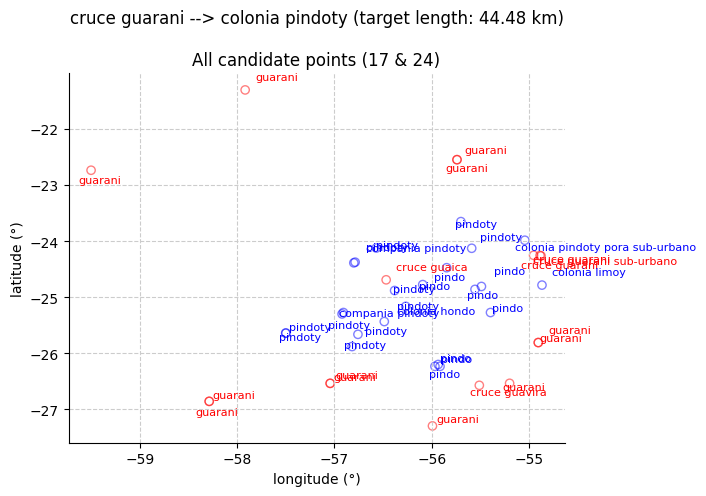

In [34]:
def plot_cadidate_points(info):
    if info.get('route', None) is None:
        print(pformat(info))
        return
    fig = plt.figure()
    wb_length = info['wb_length']
    p1 = info['p1_name']
    p2 = info['p2_name']
    title = f'{p1} --> {p2} (target length: {wb_length:.2f} km)\n'
    
    p1_pts = np.array([p.coords[0] for p in info['p1_candidates']])
    p2_pts = np.array([p.coords[0] for p in info['p2_candidates']])
    plt.scatter(*p1_pts.T, ec='red', alpha=0.5, fc='none')
    plt.scatter(*p2_pts.T, ec='blue', alpha=0.5, fc='none')
    for p, v in info['p1_candidate_names'].items():
        off = np.random.randint(-10, 10)
        plt.annotate(v, xy=(p[0], p[1]), xytext=(off, off), textcoords='offset points', alpha=1, color='red', fontsize=8)
    for p, v in info['p2_candidate_names'].items():
        off = np.random.randint(-10, 10)
        plt.annotate(v, xy=(p[0], p[1]), xytext=(off, off), textcoords='offset points', alpha=1, color='blue', fontsize=8)

    plt.title(f'{title}\nAll candidate points ({len(info["p1_candidates"])} & {len(info["p2_candidates"])})')
    plt.xlabel('longitude (°)')
    plt.ylabel('latitude (°)')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(color='#ccc', linestyle='--')

    plt.show()
    return fig
    
fig = plot_cadidate_points(info)
fig.savefig('candidate_points.png', bbox_inches='tight', pad_inches=0.2)

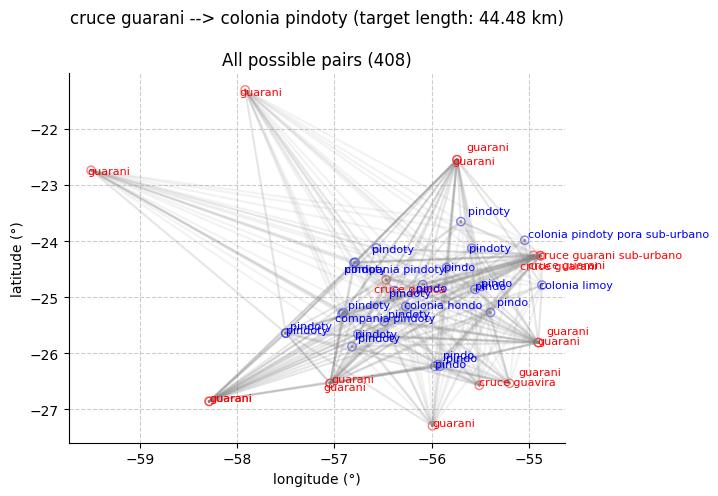

In [35]:
def plot_all_pairs(info):
    if info.get('route', None) is None:
        print(pformat(info))
        return
    fig = plt.figure()
    wb_length = info['wb_length']
    p1 = info['p1_name']
    p2 = info['p2_name']
    all_pairs = [(_p1, _p2) for _p1, _p2 in product(info['p1_candidates'], info['p2_candidates']) if _p1 != _p2]
    title = f'{p1} --> {p2} (target length: {wb_length:.2f} km)\n'
    
    p1_pts = np.array([p.coords[0] for p in info['p1_candidates']])
    p2_pts = np.array([p.coords[0] for p in info['p2_candidates']])
    plt.scatter(*p1_pts.T, ec='red', alpha=0.5, fc='none')
    plt.scatter(*p2_pts.T, ec='blue', alpha=0.5, fc='none')
    for p, v in info['p1_candidate_names'].items():
        off = np.random.randint(-10, 10)
        plt.annotate(v, xy=(p[0], p[1]), xytext=(off, off), textcoords='offset points', alpha=1, color='red', fontsize=8)
    for p, v in info['p2_candidate_names'].items():
        off = np.random.randint(-10, 10)
        plt.annotate(v, xy=(p[0], p[1]), xytext=(off, off), textcoords='offset points', alpha=1, color='blue', fontsize=8)

    for p1, p2 in all_pairs:
        d = straight_line_distance(p1, p2) / 1e3
        p1 = p1.coords[0]
        p2 = p2.coords[0]
        x, y = np.array([p1, p2]).T
        plt.plot(x, y, color='gray', alpha=0.1)

    plt.title(f'{title}\nAll possible pairs ({len(all_pairs)})')
    plt.xlabel('longitude (°)')
    plt.ylabel('latitude (°)')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(color='#ccc', linestyle='--')
    plt.show()
    return fig
    
fig = plot_all_pairs(info)
fig.savefig('all_pairs.png', bbox_inches='tight', pad_inches=0.2)

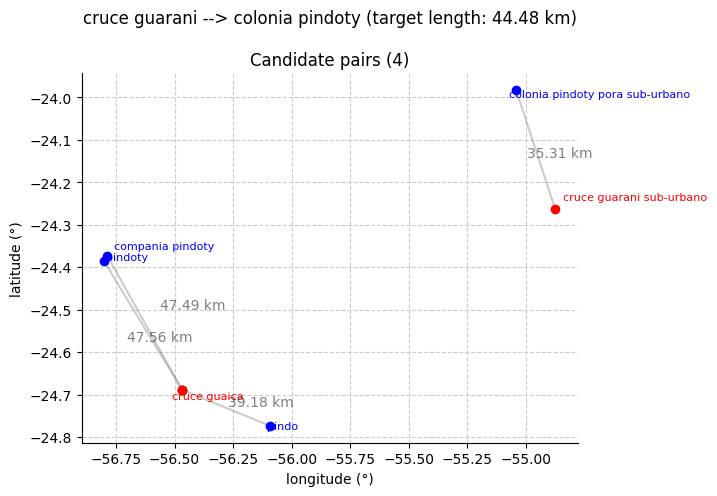

In [36]:
def plot_candidate_pairs(info):
    if info.get('route', None) is None:
        print(pformat(info))
        return
    fig = plt.figure()
    wb_length = info['wb_length']
    p1 = info['p1_name']
    p2 = info['p2_name']
    all_pairs = [(_p1, _p2) for _p1, _p2 in product(info['p1_candidates'], info['p2_candidates']) if _p1 != _p2]
    title = f'{p1} --> {p2} (target length: {wb_length:.2f} km)\n'

    points_already_plotted = set()
    for p1, p2 in all_pairs:
        d = straight_line_distance(p1, p2) / 1e3
        if abs(d - wb_length) > 10:
            continue
        p1 = p1.coords[0]
        p1_name = info['p1_candidate_names'][p1]

        p2 = p2.coords[0]
        p2_name = info['p2_candidate_names'][p2]
        
        x, y = np.array([p1, p2]).T
        plt.plot(x, y, color='gray', alpha=0.4)
        
        off = np.random.randint(-15, 15)
        plt.annotate(f'{d:.2f} km', xy=(x.mean(), y.mean()), xytext=(off, off), textcoords='offset points', alpha=.5)
        
        plt.scatter(x[0], y[0], color='red', zorder=100)
        plt.scatter(x[1], y[1], color='blue', zorder=100)
        
        if p1 not in points_already_plotted:
            off = np.random.randint(-10, 10)
            plt.annotate(p1_name, xy=(p1[0], p1[1]), xytext=(off, off), textcoords='offset points', alpha=1, color='red', fontsize=8)
        
        if p2 not in points_already_plotted:
            off = np.random.randint(-10, 10)
            plt.annotate(p2_name, xy=(p2[0], p2[1]), xytext=(off, off), textcoords='offset points', alpha=1, color='blue', fontsize=8)
        
        points_already_plotted.add(p1)
        points_already_plotted.add(p2)

    plt.title(f'{title}\nCandidate pairs ({len(info["candidate_pairs"])})')
    plt.xlabel('longitude (°)')
    plt.ylabel('latitude (°)')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(color='#ccc', linestyle='--')
    
#     y0, y1 = plt.gca().get_ylim()
#     x0, x1 = plt.gca().get_xlim()
#     print(x0, x1)
#     print(y0, y1)
#     roads = gdf_r.cx[x0:x1, y0:y1]
#     print(len(roads))
#     roads.geometry.plot(ax=plt.gca(), alpha=0.2, color='#ccc')
    
    plt.show()
    return fig
    
fig = plot_candidate_pairs(info)
fig.savefig('candidate_pairs.png', bbox_inches='tight', pad_inches=0.2)

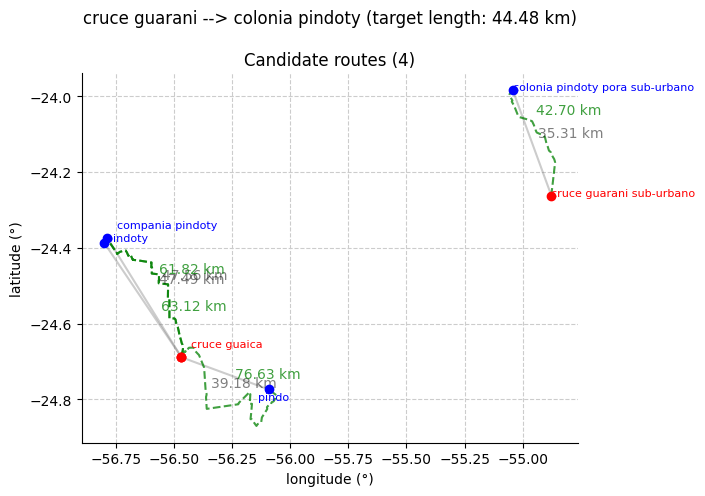

In [37]:
def plot_candidate_routes(info):
    if info.get('route', None) is None:
        print(pformat(info))
        return
    fig = plt.figure()
    wb_length = info['wb_length']
    p1 = info['p1_name']
    p2 = info['p2_name']
    all_pairs = [(_p1, _p2) for _p1, _p2 in product(info['p1_candidates'], info['p2_candidates']) if _p1 != _p2]
    title = f'{p1} --> {p2} (target length: {wb_length:.2f} km)\n'

    points_already_plotted = set()
    for p1, p2 in all_pairs:
        d = straight_line_distance(p1, p2) / 1e3
        if abs(d - wb_length) > 10:
            continue
        p1 = p1.coords[0]
        p1_name = info['p1_candidate_names'][p1]

        p2 = p2.coords[0]
        p2_name = info['p2_candidate_names'][p2]
        
        x, y = np.array([p1, p2]).T
        plt.plot(x, y, color='gray', alpha=0.4)
        
        off = np.random.randint(-15, 15)
        plt.annotate(f'{d:.2f} km', xy=(x.mean(), y.mean()), xytext=(off, off), textcoords='offset points', alpha=.5)
        
        plt.scatter(x[0], y[0], color='red', zorder=100)
        plt.scatter(x[1], y[1], color='blue', zorder=100)
        
        if p1 not in points_already_plotted:
            off = np.random.randint(-10, 10)
            plt.annotate(p1_name, xy=(p1[0], p1[1]), xytext=(off, off), textcoords='offset points', alpha=1, color='red', fontsize=8)
        
        if p2 not in points_already_plotted:
            off = np.random.randint(-10, 10)
            plt.annotate(p2_name, xy=(p2[0], p2[1]), xytext=(off, off), textcoords='offset points', alpha=1, color='blue', fontsize=8)
        
        points_already_plotted.add(p1)
        points_already_plotted.add(p2)

    for i, r in enumerate(info['candidate_routes']):
        ps = [G.nodes[node] for node in r['route']]
        x = np.array([p['x'] for p in ps])
        y = np.array([p['y'] for p in ps])
        plt.plot(x, y, color='green', linestyle='--', alpha=.75)
        offx, offy = np.random.randint(-20, 20), np.random.randint(-20, 20)
        plt.annotate(f'{r["length"]:.2f} km', xy=(x.mean(), y.mean()), xytext=(offx, offy), textcoords='offset points', alpha=.75, color='green')

    plt.title(f'{title}\nCandidate routes ({len(info["candidate_routes"])})')
    plt.xlabel('longitude (°)')
    plt.ylabel('latitude (°)')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(color='#ccc', linestyle='--')
    
#     y0, y1 = plt.gca().get_ylim()
#     x0, x1 = plt.gca().get_xlim()
#     print(x0, x1)
#     print(y0, y1)
#     roads = gdf_r.cx[x0:x1, y0:y1]
#     print(len(roads))
#     roads.geometry.plot(ax=plt.gca(), alpha=0.2, color='#ccc')
    
    plt.show()
    return fig
    
fig = plot_candidate_routes(info)
fig.savefig('candidate_routes.png', bbox_inches='tight', pad_inches=0.2)

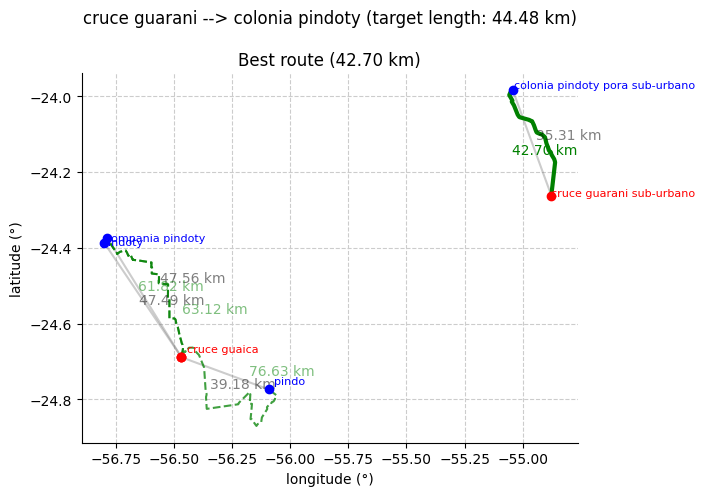

In [39]:
def plot_candidate_routes(info):
    if info.get('route', None) is None:
        print(pformat(info))
        return
    fig = plt.figure()
    wb_length = info['wb_length']
    p1 = info['p1_name']
    p2 = info['p2_name']
    all_pairs = [(_p1, _p2) for _p1, _p2 in product(info['p1_candidates'], info['p2_candidates']) if _p1 != _p2]
    title = f'{p1} --> {p2} (target length: {wb_length:.2f} km)\n'

    points_already_plotted = set()
    for p1, p2 in all_pairs:
        d = straight_line_distance(p1, p2) / 1e3
        if abs(d - wb_length) > 10:
            continue
        p1 = p1.coords[0]
        p1_name = info['p1_candidate_names'][p1]

        p2 = p2.coords[0]
        p2_name = info['p2_candidate_names'][p2]
        
        x, y = np.array([p1, p2]).T
        plt.plot(x, y, color='gray', alpha=0.4)
        
        off = np.random.randint(-15, 15)
        plt.annotate(f'{d:.2f} km', xy=(x.mean(), y.mean()), xytext=(off, off), textcoords='offset points', alpha=.5)
        
        plt.scatter(x[0], y[0], color='red', zorder=100)
        plt.scatter(x[1], y[1], color='blue', zorder=100)
        
        if p1 not in points_already_plotted:
            off = np.random.randint(-10, 10)
            plt.annotate(p1_name, xy=(p1[0], p1[1]), xytext=(off, off), textcoords='offset points', alpha=1, color='red', fontsize=8)
        
        if p2 not in points_already_plotted:
            off = np.random.randint(-10, 10)
            plt.annotate(p2_name, xy=(p2[0], p2[1]), xytext=(off, off), textcoords='offset points', alpha=1, color='blue', fontsize=8)
        
        points_already_plotted.add(p1)
        points_already_plotted.add(p2)

    for i, r in enumerate(info['candidate_routes']):
        ps = [G.nodes[node] for node in r['route']]
        x = np.array([p['x'] for p in ps])
        y = np.array([p['y'] for p in ps])
        if i == info['best_route_idx']:
            best_route_length = r["length"]
            plt.plot(x, y, color='green', linewidth=3)
            offx, offy = np.random.randint(-20, 20), np.random.randint(-20, 20)
            plt.annotate(f'{r["length"]:.2f} km', xy=(x.mean(), y.mean()), xytext=(offx, offy), textcoords='offset points', alpha=1, color='green')
        else:
            plt.plot(x, y, color='green', linestyle='--', alpha=.75)
            offx, offy = np.random.randint(-20, 20), np.random.randint(-20, 20)
            plt.annotate(f'{r["length"]:.2f} km', xy=(x.mean(), y.mean()), xytext=(offx, offy), textcoords='offset points', alpha=.5, color='green')

    plt.title(f'{title}\nBest route ({best_route_length:.2f} km)')
    plt.xlabel('longitude (°)')
    plt.ylabel('latitude (°)')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(color='#ccc', linestyle='--')
    plt.show()
    return fig
    
fig = plot_candidate_routes(info)
fig.savefig('best_route.png', bbox_inches='tight', pad_inches=0.2)

---
---

In [43]:
matches = []
with tqdm(df.itertuples(), total=len(df)) as bar:
    for i, row in enumerate(bar):
        wb_length = float(row.length)
        p1_name = row.endpoint_1
        p2_name = row.endpoint_2
        
        info = match(p1_name, p2_name, wb_length)
        if info.get('route') is None:
            continue
        matches.append(info)
    
        bar.set_postfix({
            'start': p1_name,
            'end': p2_name,
            'diff': info['diff'],
            'matches': len(matches)
        })
        gc.collect()

  1%|          | 1/169 [00:01<03:19,  1.19s/it]

Skipping 4 mojones -- ytoror, No candidate pairs. wb_len=0.71211177, diffs=[]
Skipping acceso sur -- villeta, No candidate pairs. wb_len=9.2907118, diffs=[]


  2%|▏         | 3/169 [00:18<09:39,  3.49s/it, start=alto vera, end=karona, diff=2.06, matches=1]

2.5115359 [14.606383  7.617536 10.023781 13.563936  0.455322]


  2%|▏         | 4/169 [00:40<24:07,  8.77s/it, start=alto vera, end=ynamb, diff=-3.08, matches=2]

10.67965 [ 3.236001 18.735493 20.268608 23.808763 14.82469  13.762351]


  3%|▎         | 5/169 [01:12<43:40, 15.98s/it, start=altos, end=atyr, diff=0.564, matches=3]     

9.3805113 [11.064711  8.816331 15.680498 10.11882  12.259599 25.236363 14.530137
 12.281757 20.260223]


  4%|▎         | 6/169 [01:13<31:17, 11.52s/it, start=altos, end=atyr, diff=0.564, matches=3]

Skipping aregua -- estacion terren, No candidate pairs. wb_len=2.0371759, diffs=[]


  4%|▍         | 7/169 [01:35<39:17, 14.55s/it, start=aregua, end=isla vall, diff=0.522, matches=4]

4.3732381 [5.445167 5.025507 3.432053 3.851713 1.145159 1.564819]


  5%|▍         | 8/169 [02:07<53:21, 19.89s/it, start=aregua, end=patin, diff=0.133, matches=5]    

6.5556202 [15.223134 15.295164 14.248965  7.22744   6.422825  6.253271  8.632808
  8.704838  7.658639]


  5%|▌         | 9/169 [06:45<4:19:28, 97.31s/it, start=arroyo san jose, end=bella vista nort, diff=-.612, matches=6]

30.643101 [32.795313 42.514629 32.795313 42.514629 41.584876 38.629881 31.254942
 45.091268 45.170513 64.397159 42.332271 39.37148  35.638642 42.91753
 27.060907 42.91753  41.319727 41.920485 58.418153 26.060877 25.273678
 24.533718 23.746519 32.258421 32.101723 34.58434  34.663585 67.40861
 68.009368 39.1441   40.839443 40.839443 77.587784 77.587784 44.536673
 44.615918 32.351992 32.195294 34.677911 34.757156 85.019786 43.966037
 75.248333 75.849091 46.983823 62.379625 37.421605 48.965964 33.109341
 48.965964 43.34612  43.946878 60.444546 38.039871 38.640629 55.138297
 52.272281 52.873039 69.370707 38.54482  45.312292 45.91305  55.776596
 32.088405 31.931707 34.414324 34.493569 24.33689  23.549691 37.421605
 63.492008 29.085203 29.085203 29.585499]


  6%|▌         | 10/169 [06:46<3:01:22, 68.44s/it, start=arroyo san jose, end=bella vista nort, diff=-.612, matches=6]

Skipping arroyo ypecuru -- ruta, No candidate pairs. wb_len=3.6359069, diffs=[]


  7%|▋         | 11/169 [06:47<2:06:57, 48.21s/it, start=arroyo san jose, end=bella vista nort, diff=-.612, matches=6]

Skipping arroyos y esteros -- 25 de diciembre, No candidate pairs. wb_len=23.2098392, diffs=[]


  7%|▋         | 12/169 [07:34<2:04:30, 47.58s/it, start=asuncion, end=san lorenzo, diff=-.29, matches=7]             

16.679355400000002 [15.251977 16.969449 24.933432 15.680684 15.968577 25.410859 15.088311
 15.376204 24.818486 12.337767 12.717442 22.027354]


  8%|▊         | 13/169 [07:35<1:27:28, 33.65s/it, start=asuncion, end=san lorenzo, diff=-.29, matches=7]

Skipping ayolas -- acceso a anacu, No candidate pairs. wb_len=1.870713, diffs=[]


  8%|▊         | 14/169 [07:36<1:01:45, 23.91s/it, start=asuncion, end=san lorenzo, diff=-.29, matches=7]

Skipping belen -- ruta 5, No candidate pairs. wb_len=10.48774, diffs=[]


  9%|▉         | 15/169 [08:50<1:39:50, 38.90s/it, start=bella vista, end=tomas romero pereira, diff=0.556, matches=8]

73.85605 [106.587121  98.150097 151.992794 141.981387  73.3005    78.837342
  73.26542   78.802262  76.931622  82.468464  75.137214  80.674056
  92.653227  84.216203  92.653227  84.216203  76.785882  82.322724]


  9%|▉         | 16/169 [09:02<1:18:44, 30.88s/it, start=benjamin aceval, end=monte lindo, diff=-7.19, matches=9]     

163.759499 [170.947063 205.106947 196.787552]


 10%|█         | 17/169 [09:24<1:11:19, 28.15s/it, start=caacupe, end=azcurr, diff=0.497, matches=10]            

5.5030961 [ 6.720444  5.006575  9.393102  7.741324  6.027455 10.413982]


 11%|█         | 18/169 [10:00<1:16:46, 30.51s/it, start=caacupe, end=eusebio ayala, diff=-.486, matches=11]

17.492827 [14.76464  17.978465 19.007599 30.497608 18.229815 29.719824 11.246008
  8.924888  8.924888 30.15474 ]


 11%|█         | 19/169 [10:30<1:15:45, 30.30s/it, start=caacupe, end=tobat, diff=0.0138, matches=12]       

16.107889 [39.396619 42.378836 16.094103 23.986989 16.998483 24.891369 26.088768
 26.152494]


 11%|█         | 19/169 [12:53<1:15:45, 30.30s/it, start=caaguazu, end=yh, diff=-.195, matches=13]   

49.833149 [ 67.287655  87.004787  76.083765 100.6222    79.654143  77.082025
  73.512643  67.733267  50.52501   60.608367  49.404852  51.066407
  49.128898  54.241123  65.484538  50.028314  60.111671  48.908156
  50.569711  48.632202  51.992394  67.381911  74.188251  79.336612
  56.75425   66.837607  55.634092  57.295647  55.358138  80.334872
  60.696107  89.613072  75.097742  87.285515  73.482581  88.283775
  64.727951]


 12%|█▏        | 21/169 [13:05<1:59:45, 48.55s/it, start=caapucu, end=villa florid, diff=-1.85, matches=14]

19.567619 [21.41612  25.992031 26.420648]


 13%|█▎        | 22/169 [13:17<1:32:02, 37.57s/it, start=caazapa, end=macie, diff=-.781, matches=15]       

10.59524 [11.376129 30.565064 20.999172]


 14%|█▎        | 23/169 [13:32<1:15:09, 30.89s/it, start=caballero alvarez, end=salto del guaira, diff=-.809, matches=16]

39.1276822 [39.936766 42.716117 43.370419 46.14977 ]


 14%|█▍        | 24/169 [13:33<53:04, 21.96s/it, start=caballero alvarez, end=salto del guaira, diff=-.809, matches=16]  

Skipping calle 11 de setiembre -- pac, No candidate pairs. wb_len=2.4410789, diffs=[]


 15%|█▍        | 25/169 [14:29<1:17:20, 32.23s/it, start=calle san luis, end=asentamiento manduar, diff=0.395, matches=17]

16.21085 [15.695246 19.67991  20.949688 25.373417 40.936266 25.571921 15.815447
 19.800111 21.057266 33.102326  9.664895 24.130921 33.25846   9.821029
 36.397522]


 15%|█▌        | 26/169 [14:30<54:09, 22.72s/it, start=calle san luis, end=asentamiento manduar, diff=0.395, matches=17]  

Skipping campo jordan -- pac, No candidate pairs. wb_len=2.5713539, diffs=[]


 16%|█▌        | 27/169 [14:53<53:56, 22.79s/it, start=capiata, end=itaugu, diff=-1.61, matches=18]                     

8.9418383 [13.758647 10.554932 10.634399 14.671376 11.952662 12.028015]


 17%|█▋        | 28/169 [15:08<47:57, 20.41s/it, start=capiata, end=posta ybycu, diff=-.837, matches=19]

4.9474888 [5.784133 5.795603 3.024087 3.035557]


 17%|█▋        | 29/169 [15:09<34:04, 14.60s/it, start=capiata, end=posta ybycu, diff=-.837, matches=19]

Skipping capitan bado -- col pto panader, No candidate pairs. wb_len=13.47495, diffs=[]


 18%|█▊        | 30/169 [15:13<26:39, 11.50s/it, start=capitan bado, end=pedro juan caballer, diff=-7.01, matches=20]

6.2295918 [13.235202]


 18%|█▊        | 31/169 [16:00<50:51, 22.11s/it, start=caraguatay, end=santa elen, diff=-1.92, matches=21]           

20.540621 [22.460693 24.008592 22.460693 25.666859 27.308413 28.856312 27.308413
 27.31355  26.132088 26.132088 40.612031 17.053843 17.715565]


 19%|█▉        | 32/169 [16:08<40:40, 17.81s/it, start=caraguatay, end=vapor cu, diff=2.41, matches=22]   

2.439111 [5.318176 0.033738]


 20%|█▉        | 33/169 [16:30<43:31, 19.21s/it, start=carapegua, end=san roque gonzalez, diff=0.221, matches=23]

14.73086929 [14.268097 14.510163 20.641247 20.883313 23.837812 24.079878]


 20%|██        | 34/169 [17:26<1:08:02, 30.24s/it, start=carmen del parana, end=encarnacio, diff=0.507, matches=24]

23.7484 [37.480555 41.741079 28.290434 34.730701 34.546126 38.80665  25.356005
 31.796272 29.920381 34.180905 20.73026  27.170527 21.20301  23.241088
 21.100675]


 21%|██        | 35/169 [17:42<57:51, 25.91s/it, start=carmen del parana, end=encarnacion, diff=-10.1, matches=25]  

10.99488783 [34.180905 21.20301  23.241088 21.100675]


 21%|██▏       | 36/169 [18:57<1:29:57, 40.58s/it, start=cecilio baez, end=san joaqui, diff=0.149, matches=26]    

22.67668 [36.650787 30.000053 22.940033 23.108077 19.689894 22.204363 36.070814
 30.580049 22.36006  22.528104 19.109921 21.62439  30.301843 29.763391
 24.823489 43.752588 36.036656 20.362173 20.262048 24.823489 36.036656]


 22%|██▏       | 37/169 [19:20<1:18:00, 35.46s/it, start=circunvalacion lambare, end=madame linch, diff=-.114, matches=27]

11.80420379 [10.82339  10.892702 11.917982 11.987294 13.000845 13.070157]


 22%|██▏       | 38/169 [19:25<57:34, 26.37s/it, start=circunvalacion santani, end=guayaib, diff=-12.1, matches=28]       

10.31845 [22.377868]


 23%|██▎       | 39/169 [19:34<45:25, 20.97s/it, start=circunvalacion santani, end=guayaibi, diff=-8.33, matches=29]

14.0456659 [24.131001 22.377868]


 24%|██▎       | 40/169 [19:43<37:08, 17.28s/it, start=colonia cleto romero, end=juan de men, diff=-13.7, matches=30]

17.20467 [30.928869 35.224518]


 24%|██▍       | 41/169 [19:48<29:11, 13.69s/it, start=concepcion, end=pozo colorado, diff=-59.7, matches=31]        

146.5854471 [206.272939]


 25%|██▍       | 42/169 [20:14<36:39, 17.32s/it, start=concepcion, end=vallem, diff=-54.4, matches=32]       

183.0303 [261.457022 277.440775 237.400288 237.400288]


 25%|██▌       | 43/169 [20:50<48:32, 23.11s/it, start=costa fleitas, end=yuquyt, diff=-1.9, matches=33]

7.133822 [10.694644  9.519088  2.171946  9.032854 11.869644 10.694088  3.346946
 11.318552 10.142996  2.795854]


 26%|██▌       | 44/169 [20:55<36:45, 17.64s/it, start=cruce  villeta, end=arroyo para, diff=2.54, matches=34]

24.53022 [21.985501]


 27%|██▋       | 45/169 [20:56<25:50, 12.50s/it, start=cruce  villeta, end=arroyo para, diff=2.54, matches=34]

Skipping cruce curumbey -- caballero alvarez, No candidate pairs. wb_len=20.8543831, diffs=[]


 27%|██▋       | 45/169 [21:07<25:50, 12.50s/it, start=cruce guarani, end=colonia pindoty, diff=1.77, matches=35]

44.47736337 [61.823636 76.631141 42.702721]


 28%|██▊       | 47/169 [21:22<26:43, 13.15s/it, start=cruce ruta 5, end=bella vista norte, diff=-51.6, matches=36]

97.371277 [148.934777 156.205354 155.806194]


 28%|██▊       | 48/169 [21:24<19:13,  9.54s/it, start=cruce ruta 5, end=bella vista norte, diff=-51.6, matches=36]

Skipping cruce santa fe -- pai corone, No candidate pairs. wb_len=45.08411, diffs=[]


 29%|██▉       | 49/169 [21:25<14:02,  7.02s/it, start=cruce ruta 5, end=bella vista norte, diff=-51.6, matches=36]

Skipping curuguaty -- ygatim, No candidate pairs. wb_len=84.392891, diffs=[]


 30%|██▉       | 50/169 [21:55<27:32, 13.89s/it, start=desv guarambare, end=emp ruta guarambare villet, diff=-1.13, matches=37]

4.187758 [ 2.355055  2.355055  5.318057  0.441039 11.898564  5.759096  0.441039
 12.339603]


 30%|███       | 51/169 [22:52<52:41, 26.79s/it, start=edelira, end=natali, diff=-.615, matches=38]                            

14.80609 [57.164863 20.087514 15.421222 25.402832 16.228753 48.318717 41.269665
 35.551457 30.608682 37.410904 60.56779  40.32573  34.607522 29.664747
 36.466969]


 31%|███       | 52/169 [23:14<49:46, 25.52s/it, start=emboscada, end=arroyos y estero, diff=-.433, matches=39]

28.586399 [27.991881 21.588534 29.018956 29.283614 22.880267 30.310689]


 31%|███▏      | 53/169 [23:29<43:14, 22.37s/it, start=emboscada, end=nueva colombi, diff=-.736, matches=40]   

10.12898 [10.86481  13.760947 12.084874 15.05268 ]


 32%|███▏      | 54/169 [23:30<30:21, 15.84s/it, start=emboscada, end=nueva colombi, diff=-.736, matches=40]

Skipping encarnacion -- itacu, No candidate pairs. wb_len=8.0875835, diffs=[]


 33%|███▎      | 55/169 [23:59<37:28, 19.72s/it, start=eusebio ayala, end=isla puc, diff=0.0989, matches=41]

11.40473 [19.602435 17.20359  11.265555 12.104559  9.653576 11.305804 12.144808
  4.412801]


 33%|███▎      | 56/169 [24:14<34:33, 18.35s/it, start=eusebio ayala, end=itacurubi de la cordiller, diff=-2.48, matches=42]

13.14974 [15.632797 16.099015 25.407117 25.873335]


 34%|███▎      | 57/169 [24:15<24:35, 13.18s/it, start=eusebio ayala, end=itacurubi de la cordiller, diff=-2.48, matches=42]

Skipping filadelfia -- emp py09, No candidate pairs. wb_len=18.5645618, diffs=[]


 34%|███▍      | 58/169 [24:27<23:49, 12.87s/it, start=horqueta, end=yby yau, diff=0.398, matches=43]                       

69.69239999999999 [108.560506  98.147349  69.294033]


 34%|███▍      | 58/169 [24:36<23:49, 12.87s/it, start=inicio concesion tape pora, end=ciudad del est, diff=-11.1, matches=44]

79.281593 [90.420907 91.31217 ]


 36%|███▌      | 60/169 [24:36<15:10,  8.36s/it, start=inicio concesion tape pora, end=ciudad del est, diff=-11.1, matches=44]

Skipping inicio tape pora -- ciudad del est, No candidate pairs. wb_len=1.292715, diffs=[]


 36%|███▌      | 61/169 [25:24<36:18, 20.17s/it, start=isla pucu, end=caraguata, diff=-.133, matches=45]                      

10.71189 [16.334637 10.845156 15.692876 15.495633 10.006152 14.853872  4.212007
 10.205682  4.853768 17.030658 17.639944 19.930337 16.998183 20.314527]


 37%|███▋      | 62/169 [25:45<36:14, 20.33s/it, start=ita, end=itaugu, diff=-.841, matches=46]         

13.07132 [11.018696 14.556734 14.630674 13.912354 17.450392 17.524332]


 37%|███▋      | 63/169 [26:10<38:21, 21.71s/it, start=ita, end=las piedra, diff=-1.64, matches=47]

5.9875221 [ 8.553408  8.878815  7.631289 12.313965 12.639372 11.391846 20.231955]


 38%|███▊      | 64/169 [26:33<38:53, 22.22s/it, start=itacurubi de la cordillera, end=valenzuel, diff=-2.13, matches=48]

14.63458 [24.276168 23.649461 17.389802 16.763095 25.779518 25.152811]


 38%|███▊      | 65/169 [29:35<2:01:40, 70.20s/it, start=itacurubi del rosario, end=san estanisla, diff=1.06, matches=49]

49.561451 [ 45.529267  54.648977  53.062746  64.514798  67.408456  65.771931
  60.389958  63.905747  89.726991  65.142866  70.860603  69.623484
  54.501955  52.349085 104.74417   62.516178  58.123833  44.36183
  53.48154   70.943135  45.776507 104.866438  85.799291  66.250647
  65.888715  48.503687  82.381888  84.71339   85.950509  80.72408
  44.36183   53.48154   62.629548  58.237203  84.283934  85.521053
  70.833677  69.596558  80.268045  65.645125  60.263152  63.778941
  89.853797  65.01606   66.144601  65.782669  48.397641  82.275842]


 39%|███▉      | 66/169 [30:06<1:40:01, 58.27s/it, start=itaugua, end=patin, diff=0.11, matches=50]                      

5.1514368 [8.578269 9.168841 9.552438 5.041519 5.951114 6.015688 4.966291 6.044593
 5.94046 ]


 39%|███▉      | 66/169 [30:36<1:40:01, 58.27s/it, start=itaugua, end=ypacaray, diff=0.0079, matches=51]

9.4667752 [10.30338  12.422682 12.382196  7.430752  9.534107  8.845446  7.341897
  9.458879  8.770218]


 40%|████      | 68/169 [31:08<1:14:49, 44.45s/it, start=km 40 ypacarai, end=san bernardin, diff=1.65, matches=52]

7.1440978 [ 9.185808 13.603832 15.036191  5.490289  9.908313 11.340672 19.615076
 24.0331   25.465459]


 40%|████      | 68/169 [31:35<1:14:49, 44.45s/it, start=km 40 ypacaray, end=san bernardin, diff=-3.04, matches=53]

2.452776 [ 9.185808 13.603832  5.490289  9.908313 11.340672 19.615076 24.0331
 25.465459]


 41%|████▏     | 70/169 [31:36<45:54, 27.83s/it, start=km 40 ypacaray, end=san bernardin, diff=-3.04, matches=53]  

Skipping km7 -- supercarreter, No candidate pairs. wb_len=6.8561211, diffs=[]


 42%|████▏     | 71/169 [31:38<32:21, 19.81s/it, start=km 40 ypacaray, end=san bernardin, diff=-3.04, matches=53]

Skipping kressburgo mayor otano -- mayor otan, No candidate pairs. wb_len=2.773576, diffs=[]


 43%|████▎     | 72/169 [31:39<22:56, 14.19s/it, start=km 40 ypacaray, end=san bernardin, diff=-3.04, matches=53]

Skipping la patria -- infante rivarol, No candidate pairs. wb_len=108.4657, diffs=[]


 43%|████▎     | 73/169 [31:53<23:00, 14.38s/it, start=limpio, end=luque, diff=-.565, matches=54]                

13.4240281 [14.031793 11.951094 13.989153 11.740868]


 43%|████▎     | 73/169 [32:46<23:00, 14.38s/it, start=loma grande, end=alto, diff=1.09, matches=55]

10.82236 [12.941588  9.735531 33.35525  23.108331 27.896961 28.099849 28.99076
 28.99076  23.108331 27.896961 28.099849 12.122692  8.916635 17.585382
 14.379325]


 44%|████▍     | 75/169 [33:38<52:43, 33.66s/it, start=los cedrales, end=santa ros, diff=-.532, matches=56]

28.15835 [40.264007 44.937132 28.690549 47.155999 24.899331 40.135368 24.995411
 29.27712  47.74257  40.263398 43.871184 33.012936 51.478386 30.002622
 29.850826]


 45%|████▍     | 76/169 [33:58<45:56, 29.64s/it, start=luque, end=aregua, diff=-.201, matches=57]          

12.62387002 [ 8.63712  13.005137 12.918834  6.155371 12.825241 10.538347]


 46%|████▌     | 77/169 [34:19<41:30, 27.07s/it, start=luque, end=rio salado_lim 3 dpto cordiller, diff=-2.43, matches=58]

8.1479816 [17.491268 14.252929 13.233145 15.242983 11.595761 10.575977]


 46%|████▌     | 78/169 [34:35<35:49, 23.62s/it, start=luque, end=san bernardino, diff=-13.2, matches=59]                 

15.6072501 [33.101038 33.360548 28.759917 29.019427]


 46%|████▌     | 78/169 [34:55<35:49, 23.62s/it, start=luque, end=san lorenzo, diff=0.234, matches=60]   

8.895617609999999 [ 8.661433 10.378905 15.785429 13.000059 14.717531 19.011641]


 47%|████▋     | 79/169 [35:03<34:02, 22.69s/it, start=maciel, end=berton, diff=-10.1, matches=61]    

16.126579 [26.24413  39.300684]


 47%|████▋     | 80/169 [36:18<27:13, 18.36s/it, start=mbocayaty, end=independencia, diff=-.983, matches=62]

25.657875 [20.359752 32.441336 26.640419 47.537654 47.75362  57.982417 58.198383
 56.928787 57.144753 48.310228 48.526194 48.571911 48.787877 49.322759
 56.902626 57.118592]


 49%|████▊     | 82/169 [36:53<50:59, 35.17s/it, start=mbocayaty del guaira, end=villarric, diff=-.88, matches=63]

6.4873781 [38.938658  3.796357  5.183551  7.367026 14.948825  9.269068 11.452543
 19.034342 19.904316 23.700673]


 49%|████▉     | 83/169 [37:11<42:49, 29.87s/it, start=moises bertoni, end=yut, diff=-34.2, matches=64]           

57.156879 [111.279498 108.602836  97.878628  91.3342  ]


 50%|████▉     | 84/169 [37:25<35:35, 25.12s/it, start=monte lindo, end=pozo colorad, diff=0.613, matches=65]

56.804871 [70.526185 64.511457 62.20679  56.192062]


 50%|████▉     | 84/169 [37:53<35:35, 25.12s/it, start=natalio, end=pto palom, diff=3.08, matches=66]        

13.34625 [22.372675 22.442222 24.521816 24.591363 10.192747 10.262294 22.444659
 22.514206]


 51%|█████     | 86/169 [38:15<34:11, 24.71s/it, start=natalio, end=yatytay, diff=1.14, matches=67]  

26.5845924 [23.967154 25.449139 42.659173 44.141158 58.25358  30.821298]


 51%|█████▏    | 87/169 [38:15<23:50, 17.45s/it, start=natalio, end=yatytay, diff=1.14, matches=67]

Skipping natalio a yatytay -- ciudad del est, No candidate pairs. wb_len=9.5220737, diffs=[]


 52%|█████▏    | 88/169 [40:59<1:22:41, 61.26s/it, start=nemby, end=san antonio, diff=0.193, matches=68]

4.2273453181 [25.851092 23.848406 20.43318  25.656539 23.653853 10.669607  5.742615
 11.801579 10.306727  4.03459   9.960148 12.135014  9.550586 11.801579
  6.445771 12.504735 10.387445  4.737746  9.54938  12.83817   9.139818
 12.504735  5.742615 11.801579 10.306727  4.03459   9.960148 12.135014
  9.550586 11.801579  3.59934  13.371194 12.625586  3.580948  7.290875
 13.704629  6.881313 13.371194 18.515762 17.670815  6.319918 12.378882
 10.261592  4.611893  9.675233 12.712317  9.265671 12.378882]


 53%|█████▎    | 89/169 [42:05<1:23:51, 62.90s/it, start=nemby, end=ytoror, diff=-3.66, matches=69]     

0.1792243 [7.627498 6.505751 6.638815 7.635548 7.21673  6.094983 6.228047 7.22478
 7.627498 6.505751 6.638815 7.635548 4.958225 3.836478 3.969542 4.966275
 7.342583 6.220836 6.3539   7.350633]


 53%|█████▎    | 90/169 [42:27<1:06:25, 50.44s/it, start=numi, end=san salvado, diff=1.63, matches=70]

15.43769 [11.133399 18.919232 17.263728 13.804921 21.590754 19.93525 ]


 54%|█████▍    | 91/169 [42:51<55:27, 42.66s/it, start=paraguari, end=carapegua, diff=0.0554, matches=71]  

19.3071109 [34.157245 20.906365 32.888793 19.251739 31.234167 25.046686 37.029114]


 54%|█████▍    | 92/169 [43:35<55:02, 42.89s/it, start=paso pe, end=loma grand, diff=-1.33, matches=72]  

12.39173 [35.512439 22.60648  51.550492 53.687244 17.912686 16.354556 17.170152
 18.510386 53.008888 13.726458 57.994699 13.726458]


 55%|█████▌    | 93/169 [44:08<50:40, 40.01s/it, start=patino, end=ypacara, diff=-1.11, matches=73]    

7.6811681 [ 8.789844 10.8545    3.803927 13.381866 15.485221  9.179503  9.335259
 11.399915  2.829758]


 56%|█████▌    | 94/169 [44:38<46:07, 36.90s/it, start=pdte franco, end=cedrale, diff=0.61, matches=74]

21.15749 [19.067936 22.707134 19.067327 18.732528 18.60348  14.520911 20.547935
 20.418887]


 56%|█████▌    | 95/169 [45:18<46:43, 37.89s/it, start=pilar, end=isla umb, diff=-2.38, matches=75]    

11.647 [14.023217 17.159177 14.023217 17.159177 15.380584 18.516544 21.724609
 24.860569 18.067367 21.443158  7.9089  ]


 57%|█████▋    | 96/169 [45:33<37:57, 31.19s/it, start=piquete cue, end=limpi, diff=-.402, matches=76]

7.9262438 [8.328503 6.419938 8.375866 6.467301]


 57%|█████▋    | 97/169 [46:03<36:49, 30.68s/it, start=puerto cantera, end=alvorada, diff=-.963, matches=77]

4.1077809 [ 8.106314  7.321621 18.410012  7.911666  7.126973 16.354042  5.855696
  5.071003]


 58%|█████▊    | 98/169 [46:04<25:52, 21.86s/it, start=puerto cantera, end=alvorada, diff=-.963, matches=77]

Skipping py01 km 15 -- reduto cuartel de la victori, No candidate pairs. wb_len=7.16397, diffs=[]


 59%|█████▊    | 99/169 [46:39<29:53, 25.63s/it, start=quiindy, end=caapucu, diff=2.07, matches=78]         

33.735059 [48.722516 49.101258 31.66411  68.134706 27.387628 63.858224 37.61828
 74.088876 50.626343]


 59%|█████▉    | 100/169 [46:58<27:16, 23.72s/it, start=ramal ruta 8, end=santa catalin, diff=-6.44, matches=79]

3.800467 [10.243274 10.243274 11.439173 17.295308 13.646406]


 60%|█████▉    | 101/169 [47:52<37:21, 32.96s/it, start=reducto, end=nemb, diff=-2.51, matches=80]              

2.649821 [5.280378 5.361096 5.280378 7.949651 5.235243 5.208459 5.289177 5.208459
 7.877732 5.163324 5.312495 5.393213 5.312495 7.981768 5.26736 ]


 60%|██████    | 102/169 [48:15<33:20, 29.86s/it, start=repatriacion, end=caaguaz, diff=-1.83, matches=81]

11.18253 [16.643946 17.737151 20.843826  9.331753 13.011456 18.373235]


 61%|██████    | 103/169 [48:16<23:22, 21.25s/it, start=repatriacion, end=caaguaz, diff=-1.83, matches=81]

Skipping rodriguez de francia -- paso medi, No candidate pairs. wb_len=2.3629651, diffs=[]


 62%|██████▏   | 104/169 [48:17<16:29, 15.22s/it, start=repatriacion, end=caaguaz, diff=-1.83, matches=81]

Skipping rotonda desvio remanso -- cruce semide, No candidate pairs. wb_len=5.2801051, diffs=[]


 62%|██████▏   | 105/169 [49:09<27:47, 26.05s/it, start=ruta 2, end=aldana canad, diff=-7.46, matches=82] 

12.08057 [19.975659 23.105962 19.538915 22.882196 20.922674 20.922674 19.966194
 22.965832 26.096135 22.529088 25.872369 23.912847 23.912847 22.956367]


 63%|██████▎   | 106/169 [49:32<26:24, 25.15s/it, start=ruta 3, end=ex caballeri, diff=0.229, matches=83]

1.853524 [15.388742 13.033398  1.624131  1.618805  1.624131  1.618805]


 63%|██████▎   | 107/169 [49:33<18:32, 17.95s/it, start=ruta 3, end=ex caballeri, diff=0.229, matches=83]

Skipping ruta 7 km 14 -- cedrales, No candidate pairs. wb_len=20.632039, diffs=[]


 64%|██████▍   | 108/169 [49:41<15:25, 15.18s/it, start=ruta 7 km 4, end=pte franco, diff=-27, matches=84]

8.31018029 [35.329216 35.329216]


 64%|██████▍   | 109/169 [49:47<12:07, 12.13s/it, start=ruta 9, end=loma plat, diff=-22.9, matches=85]    

20.985889 [43.883566]


 65%|██████▌   | 110/169 [49:51<09:43,  9.89s/it, start=ruta 9, end=neulan, diff=-45.6, matches=86]   

20.671471 [66.285022]


 66%|██████▌   | 111/169 [50:07<11:09, 11.55s/it, start=ruta a pirayu, end=lim distrito caacup, diff=0.0992, matches=87]

1.1837029 [1.084494 1.359837 0.964358 7.700804]


 66%|██████▋   | 112/169 [51:03<23:45, 25.00s/it, start=ruta acceso sur nemby ruta py01, end=villa elis, diff=-1.86, matches=88]

6.6379042 [11.532214 15.436063  9.373489  8.495734  9.889088 12.23537  15.463799
 10.076645  9.19889  10.592244 11.532214 15.436063  9.373489  8.495734
  9.889088]


 67%|██████▋   | 113/169 [51:04<16:39, 17.84s/it, start=ruta acceso sur nemby ruta py01, end=villa elis, diff=-1.86, matches=88]

Skipping ruta py01 -- guarambar, No candidate pairs. wb_len=5.4656229, diffs=[]


 67%|██████▋   | 114/169 [51:05<11:45, 12.83s/it, start=ruta acceso sur nemby ruta py01, end=villa elis, diff=-1.86, matches=88]

Skipping ruta py02 -- mcal lope, No candidate pairs. wb_len=19.16538, diffs=[]


 68%|██████▊   | 115/169 [51:06<08:13,  9.15s/it, start=ruta acceso sur nemby ruta py01, end=villa elis, diff=-1.86, matches=88]

Skipping ruta py02 -- nueva londre, No candidate pairs. wb_len=8.2651472, diffs=[]


 69%|██████▊   | 116/169 [51:06<05:48,  6.57s/it, start=ruta acceso sur nemby ruta py01, end=villa elis, diff=-1.86, matches=88]

Skipping ruta py03 -- juan de men, No candidate pairs. wb_len=18.24349, diffs=[]


 69%|██████▉   | 117/169 [51:07<04:08,  4.78s/it, start=ruta acceso sur nemby ruta py01, end=villa elis, diff=-1.86, matches=88]

Skipping ruta py03 -- unio, No candidate pairs. wb_len=15.43812, diffs=[]


 70%|██████▉   | 118/169 [51:08<03:08,  3.70s/it, start=ruta acceso sur nemby ruta py01, end=villa elis, diff=-1.86, matches=88]

Skipping ruta py06 -- jesu, No candidate pairs. wb_len=10.41375, diffs=[]


 70%|███████   | 119/169 [55:59<1:14:52, 89.85s/it, start=ruta py06 santa rita, end=santa ros, diff=-.526, matches=89]          

20.90353 [ 18.976377  21.646731  19.130716  32.763875  32.763875  16.412811
  21.870035  16.170261  22.024374  33.250169  33.250169  46.084665
  46.379145  23.035372  29.169149  29.933503  36.06728   30.164342
  36.57685   36.884069 104.588874  20.166715  18.544593  20.166715
  20.140536  33.023759  47.508146  46.936525  46.936525  20.294875
  17.009378  17.009378  31.614842  38.302241  38.176182  24.35904
  24.72814   28.985041  21.429221  27.436452  27.968163  41.012146
  60.188286  16.088371  29.80963   35.364782  24.894378  24.894378
  29.80963   31.614842  38.302241  38.176182  30.164342  36.57685
  36.884069  20.287086  18.664964  20.287086  20.004739  33.159556
  47.628517  47.056896  47.056896  20.159078  17.145175  17.145175
  45.803411  46.097891  18.50565   13.666147  18.622048  24.504275
  24.378216  24.49563   30.629407  24.880609  31.014386]


 71%|███████   | 120/169 [56:08<53:27, 65.47s/it, start=ruta py06_km 75, end=edelir, diff=-6.61, matches=90]          

18.65922 [29.780365 25.266631]


 72%|███████▏  | 121/169 [56:09<36:55, 46.16s/it, start=ruta py06_km 75, end=edelir, diff=-6.61, matches=90]

Skipping ruta py07 -- juan manuel fruto, No candidate pairs. wb_len=3.3578711, diffs=[]


 72%|███████▏  | 121/169 [56:13<36:55, 46.16s/it, start=ruta py07, end=troch, diff=-36.1, matches=91]       

13.15935 [49.249445]


 73%|███████▎  | 123/169 [56:14<18:18, 23.89s/it, start=ruta py07, end=troch, diff=-36.1, matches=91]

Skipping ruta py08 -- cruce mainumb, No candidate pairs. wb_len=1.807254, diffs=[]


 73%|███████▎  | 124/169 [56:15<12:48, 17.08s/it, start=ruta py07, end=troch, diff=-36.1, matches=91]

Skipping ruta py10 -- friesla, No candidate pairs. wb_len=6.71456, diffs=[]


 74%|███████▍  | 125/169 [1:08:34<2:51:10, 233.41s/it, start=san alfredo, end=col san francisc, diff=-.426, matches=92]

51.120178 [ 50.444928  70.128111  60.114749  50.329695  63.877636  53.155006
  58.877721  51.67139   64.017252  58.877721 448.120525  54.39106
  56.797147 104.558426 107.254994  83.284681  70.380264 108.945417
  70.380264  82.637022  77.246854  72.248574  76.076205  78.451689
  77.246854  72.615143  72.198223  68.889281  67.889362  73.794112
  74.145887  81.596427  72.15502   63.752696  53.030066  59.55645
  51.54645   63.892312  59.55645  111.723021 114.419589  90.449276
  67.117179 116.110012  67.117179  58.519672  59.355025  59.326284
  58.519672  58.057812  55.914264  82.693352  77.796592  60.145368
  66.847491  99.727284  68.421301  99.783092  77.796592  79.207777
  72.576767  69.47463   80.323995  66.718859  61.90367   72.576767
  66.563175 152.238956  85.420962  86.420881 152.238956  67.085984
  69.764982  86.69845   55.139815  70.152376  46.438171  53.046192
  76.240575 106.558414  82.836332  70.195579  82.89214   76.128218
  65.406478  82.59953   82.59953   72.442936  69.50633

 75%|███████▍  | 126/169 [1:08:55<2:01:46, 169.92s/it, start=san bernardino, end=alto, diff=0.821, matches=93]         

7.879848 [12.97905  13.025982  8.943544 18.149931  7.058681 16.265068]


 75%|███████▌  | 127/169 [1:10:01<1:36:58, 138.55s/it, start=san estanislao, end=rio corrientes, diff=-3.18, matches=94]

43.8774394 [57.462629 58.305557 50.721735 51.564663 55.912857 66.679808 62.215959
 66.377187 61.913338 78.377526 73.930445 78.223334 74.084637 60.549479
 56.08563  47.052684 48.289803]


 76%|███████▌  | 128/169 [1:11:30<1:24:34, 123.77s/it, start=san ignacio, end=santa rosa, diff=-1.71, matches=95]       

9.521766 [18.77931  19.07379  11.35745  25.828524 12.825585 24.670561 11.231408
 12.873435 25.176335 24.018372 29.071068 32.051757 32.583468 31.083096
 32.344679 31.083096  4.609449  4.037828  4.037828 40.94985  40.94985
 23.741134 24.244325 34.053157 14.929988]


 76%|███████▋  | 129/169 [1:11:46<1:01:00, 91.51s/it, start=san isidro del curuguaty, end=itanar, diff=-1.26, matches=96] 

8.144428300000001 [ 9.405497 10.855105 81.038457 42.368013]


 76%|███████▋  | 129/169 [1:17:33<1:01:00, 91.51s/it, start=san joquin, end=yh, diff=0.0137, matches=97]                 

19.03507 [41.214319 27.044934 16.960703 28.164218 28.636427 28.440172 17.794131
 18.913415 19.385624 19.189369 43.912451 17.626087 18.745371 19.21758
 19.021325 43.744407 21.04427  10.960039 22.163554 22.635763 22.439508
 42.438011 18.529801 19.649085 20.121294 19.925039 44.648121 24.854365
 30.603065 28.812228 36.474521 36.474521 29.372637 32.134353 32.692794
 36.395981 39.179658 39.519254 94.95177  13.964136 34.399158 83.11704
 84.1153   39.607558 17.834104 26.744287 17.674664 16.517223 17.950618
 36.767154 37.910914 42.792832 43.409839 32.034348 43.791092 14.167061
 18.233907 37.87054  25.092341 21.093062 21.069237 29.97942  20.909797
 19.752356 21.185751 21.241583 18.706212 39.647854 13.029477 37.519196
 17.916593 32.169617 37.254865 36.474521 36.474521 34.517637 29.144762
 29.144762 14.856988 15.855248 18.669169 18.669169 39.179658 42.935797
 43.266874 32.177313 43.934057 14.310026 13.964136 34.399158 32.359695
 39.647854 36.395981 83.162491 84.160751 29.372637 37.254865]


 78%|███████▊  | 131/169 [1:26:44<2:59:10, 282.90s/it, start=san jose, end=san juan, diff=0.124, matches=98]

1.2472219 [5.65762700e+00 7.77120100e+00 8.15978300e+00 9.92481600e+00
 1.27396720e+01 9.92481600e+00 1.13366170e+01 1.27396720e+01
 1.15644280e+01 3.22956860e+01 3.65573140e+01 3.76805290e+01
 3.25210280e+01 3.65573140e+01 8.35768900e+00 7.70028900e+00
 1.94876570e+01 8.90427800e+00 1.41259130e+01 7.43714400e+00
 1.96400500e+00 1.96400500e+00 1.28579360e+01 1.54204700e+01
 1.54204700e+01 7.36687600e+00 9.12417400e+00 1.10439730e+01
 1.10439730e+01 1.38335600e+00 3.17721920e+01 3.92856930e+01
 3.19975340e+01 3.92856930e+01 1.00304110e+01 9.92481600e+00
 1.27396720e+01 9.92481600e+00 1.13366170e+01 1.27396720e+01
 3.48245300e+00 3.20948200e+00 3.48245300e+00 3.20948200e+00
 2.53576500e+00 2.53576500e+00 2.06646000e-01 2.52097000e-01
 8.97971000e-01 8.97971000e-01 9.92295100e+00 1.06233860e+01
 7.55038800e+00 3.25685310e+01 3.68301590e+01 3.79533740e+01
 3.27938730e+01 3.68301590e+01 7.86391000e-01 7.86391000e-01
 2.25348900e+00 2.25348900e+00 9.12417400e+00 1.47692700e+00
 2.06646000e-0

 78%|███████▊  | 131/169 [1:26:48<2:59:10, 282.90s/it, start=san jose, end=tebicuarym, diff=-18.5, matches=99]

1.333498 [19.80862]


 79%|███████▊  | 133/169 [1:27:42<1:33:19, 155.54s/it, start=san jose de los arroyos, end=coronel ovied, diff=-1.19, matches=100]

28.804871 [31.673594 30.462431 32.62336  33.300145 32.088982 34.249911 31.210805
 29.999642 32.160571 32.862693 33.834394 38.382046 31.35377  30.142607
 32.303536]


 79%|███████▉  | 134/169 [1:27:49<1:04:52, 111.20s/it, start=san juan, end=aba, diff=-16.5, matches=101]                         

8.6752167 [26.491672 25.152045]


 80%|███████▉  | 135/169 [1:27:50<44:12, 78.01s/it, start=san juan, end=aba, diff=-16.5, matches=101]   

Skipping san lorenzo -- acceso su, No candidate pairs. wb_len=5.7771759, diffs=[]


 80%|████████  | 136/169 [1:28:11<33:26, 60.81s/it, start=san lorenzo, end=capiata, diff=-.0895, matches=102]

8.9929518 [7.226    9.082417 7.897188 9.091805 3.058019 2.961409]


 81%|████████  | 137/169 [1:28:35<26:38, 49.95s/it, start=san lorenzo, end=nemby, diff=3.81, matches=103]    

19.946161422 [35.976573 27.598359 13.467736 13.548454 13.467736 16.137009 13.422601]


 82%|████████▏ | 138/169 [1:28:58<21:37, 41.84s/it, start=san lorenzo a agusto saldivar, end=ita, diff=1.04, matches=104]

24.99686 [23.952735 27.713292 23.827795 27.588352 19.08199  22.842547]


 82%|████████▏ | 139/169 [1:30:42<30:13, 60.45s/it, start=san miguel, end=colonia canindey, diff=-.63, matches=105]      

8.9718809 [24.472705 18.542171 12.522791 20.103161  6.230897  5.652228  6.744769
  6.704325 24.316346 24.275902  0.881954  0.84151  16.880009 16.839565
 22.956407 22.996851  9.601385  9.641829 24.820593 18.175487 12.691293
 22.751245 22.791689 23.910499 23.870055 16.880009 16.839565  0.881954
  0.84151 ]


 83%|████████▎ | 140/169 [1:31:32<27:43, 57.36s/it, start=san patricio, end=gral delgado, diff=0.095, matches=106] 

33.407989 [34.12539  34.915831 33.312978 33.089106 33.879547 32.276694 51.588624
 51.510616 39.047335 39.837776 38.234923 30.420012 35.745631 31.232424]


 83%|████████▎ | 141/169 [1:32:13<24:29, 52.50s/it, start=san pedro, end=nueva germani, diff=0.296, matches=107]  

48.606701 [68.382973 62.8154   64.915658 96.458602 89.262472 62.8154   64.915658
 50.7229   57.913851 48.310872 51.475693]


 84%|████████▍ | 142/169 [1:32:32<19:01, 42.27s/it, start=san pedro, end=san solan, diff=-12.2, matches=108]    

6.076632 [19.331115 18.318026 24.188836 31.284176 30.416175]


 85%|████████▍ | 143/169 [1:33:01<16:34, 38.25s/it, start=san pedro del parana, end=la pa, diff=-.278, matches=109]

3.097405 [46.238766  3.375015  3.469489  0.642818  3.960121  4.054595 16.620096
 15.033031]


 85%|████████▌ | 144/169 [1:33:47<16:58, 40.74s/it, start=san roque gonzalez, end=quiind, diff=-1.63, matches=110] 

10.74067 [22.015527 12.371076 28.149492 19.889148 48.312927 48.312927 23.181639
 13.537188 29.315604 21.05526  13.026511 13.026511]


 86%|████████▌ | 145/169 [1:33:58<12:44, 31.84s/it, start=san solano, end=caraguata, diff=2.9, matches=111]       

15.64962 [12.748522 30.03165  29.163649]


 86%|████████▋ | 146/169 [1:34:09<09:49, 25.63s/it, start=san solano, end=fleitas cu, diff=-10.2, matches=112]

17.50205 [27.662935 44.946063 44.078062]


 87%|████████▋ | 147/169 [1:34:51<11:11, 30.53s/it, start=santa rosa, end=san patrici, diff=-.291, matches=113]

10.46233 [11.095668 12.131952 11.464768 12.501052 10.753377 16.287688 17.323972
 48.084027 19.893928 18.298114 10.879419 19.77753 ]


 88%|████████▊ | 148/169 [1:34:52<07:36, 21.71s/it, start=santa rosa, end=san patrici, diff=-.291, matches=113]

Skipping santiago -- acceso brazo anacu, No candidate pairs. wb_len=8.1448412, diffs=[]


 88%|████████▊ | 149/169 [1:34:54<05:11, 15.57s/it, start=santa rosa, end=san patrici, diff=-.291, matches=113]

Skipping sapucai -- chauri, No candidate pairs. wb_len=0.25058761, diffs=[]


 89%|████████▉ | 150/169 [1:35:16<05:32, 17.52s/it, start=sapucai, end=chirca, diff=-3.46, matches=114]        

9.8379107 [17.433433 18.725305 13.30008  14.591952 14.072768 15.36464 ]


 89%|████████▉ | 151/169 [1:35:31<05:02, 16.81s/it, start=simon bolivar, end=cecilio bae, diff=-.183, matches=115]

9.4112453 [ 9.594414 10.17441  12.967577 13.547573]


 90%|████████▉ | 152/169 [1:36:07<06:23, 22.58s/it, start=sta catalina, end=aleman cu, diff=-6.26, matches=116]   

17.10784 [ 36.310188  39.002576  25.460881  23.366077  29.501868  53.526876
  29.501868 364.854485  53.78056 ]


 91%|█████████ | 153/169 [1:36:08<04:17, 16.12s/it, start=sta catalina, end=aleman cu, diff=-6.26, matches=116]

Skipping super carretera -- a piri pyt, No candidate pairs. wb_len=7.1127481, diffs=[]


 91%|█████████ | 154/169 [1:36:16<03:24, 13.66s/it, start=super carretera, end=itakyr, diff=-26.8, matches=117]

28.48221 [55.288297 77.042614]


 91%|█████████ | 154/169 [1:36:24<03:24, 13.66s/it, start=tobati, end=1ro de marz, diff=-1.19, matches=118]    

24.2008 [25.388718 31.077164]


 92%|█████████▏| 156/169 [1:36:47<03:16, 15.12s/it, start=tobati, end=arroyos y estero, diff=-.0619, matches=119]

24.97084 [25.032718 30.090414 25.333028 27.61941  36.217006 27.208589]


 93%|█████████▎| 157/169 [1:38:57<09:56, 49.73s/it, start=tomas romero pereira, end=santa rita, diff=2.16, matches=120]

86.597617 [439.73287  438.816246 437.119027 121.235169 120.104978 110.695527
 109.262977 109.262977  92.877943  98.776759 111.223762 110.093571
 102.258503 114.799819 114.799819  84.440919  90.339735 418.748742
 417.832118 173.816286 173.646007 416.134899 411.406746]


 93%|█████████▎| 158/169 [1:39:13<07:14, 39.48s/it, start=troche, end=navill, diff=-10.8, matches=121]                 

17.82991 [32.37392  33.041962 28.668224 28.668224]


 94%|█████████▍| 159/169 [1:40:11<07:30, 45.04s/it, start=villa florida, end=san ignacio, diff=-5.99, matches=122]

68.52962409999999 [ 95.389635  91.012564 112.308219  84.631924  84.631924  91.879667
  84.425974  90.768388  92.300535  84.846842  81.472702 130.352076
  79.097238  74.521327]


 95%|█████████▍| 160/169 [1:40:23<05:16, 35.13s/it, start=villa hayes, end=benjamin aceva, diff=3.12, matches=123]

17.00536 [13.887877 40.517159 11.823093]


 95%|█████████▍| 160/169 [1:40:57<05:16, 35.13s/it, start=villarrica, end=num, diff=-1.86, matches=124]           

25.61474 [27.47971  27.546206 32.974238 29.258817 29.325313 35.157713 42.739512
 56.653094 38.151249]


 96%|█████████▌| 162/169 [1:41:42<04:25, 37.99s/it, start=yaguaron, end=paraguar, diff=-.525, matches=125]

13.93696 [34.177111 32.522485 38.317432 16.700129 17.291386 22.63419  14.620908
 15.212165 20.554969 14.462043 15.659441 20.952429]


 96%|█████████▋| 163/169 [1:42:47<04:35, 45.93s/it, start=yaguaron, end=piray, diff=-.482, matches=126]   

10.26811 [49.777873 52.122249 45.345869 10.750522 11.71549  13.094898  7.084345
 12.153599 13.118567 14.497975  8.487422  4.452286  5.417254  6.796662
  8.81671  25.122001 20.46719  25.769155]


 97%|█████████▋| 164/169 [1:43:00<02:59, 35.97s/it, start=ybyraty, end=pilar, diff=-14.8, matches=127] 

86.7027478 [103.826191 103.826191 101.474464]


 98%|█████████▊| 165/169 [1:43:23<02:08, 32.07s/it, start=ypacarai, end=caacupe, diff=0.435, matches=128]

16.198262800000002 [17.670804 19.458936 13.975285 15.763417 28.167772 29.955904]


 98%|█████████▊| 166/169 [1:44:16<01:55, 38.41s/it, start=ypacaray, end=pirayu, diff=1.05, matches=129]  

12.620605 [11.153406 10.188438 13.707606 11.566805 14.664012 13.699044 17.218212
  7.871286 37.792066 33.137255 38.43922  23.151328 22.18636  25.705528
 21.996073]


 99%|█████████▉| 167/169 [1:44:45<01:11, 35.63s/it, start=ypane, end=desv guarambar, diff=-3.43, matches=130]

0.66352731 [6.729177 7.170216 6.694559 7.135598 4.094248 4.535287 8.601513 9.042552]


 99%|█████████▉| 168/169 [1:44:46<00:25, 25.29s/it, start=ypane, end=desv guarambar, diff=-3.43, matches=130]

Skipping ytororo -- cervepa, No candidate pairs. wb_len=1.6831909, diffs=[]


100%|██████████| 169/169 [1:45:50<00:00, 36.80s/it, start=ytororo, end=ypan, diff=0.0542, matches=131]       

3.657007 [35.527235 34.719436  4.239053  4.331988  6.873982  2.292609 32.019146
 31.211347  3.428648  3.602787  6.063577  2.330704  3.295584  3.469723
  5.930513  2.19764  34.128444 33.320645]


100%|██████████| 169/169 [1:45:50<00:00, 37.57s/it, start=ytororo, end=ypan, diff=0.0542, matches=131]


In [70]:
with open('matches_20210609.pkl', 'rb') as f:
    matches = pickle.load(f)

In [13]:
# with open('matches_20210610.pkl', 'rb') as f:
#     matches = pickle.load(f)

In [71]:
diffs = np.array([m['diff'] for m in matches if abs(m['diff']) < np.inf])
abs_diffs = np.abs(diffs)
rel_errs = np.array([m['rel_error'] for m in matches if abs(m['diff']) < np.inf])

In [72]:
nmatched = (abs_diffs <= 5).sum()
nmatched, nmatched / len(df)

(203, 0.6363636363636364)

In [73]:
nmatched = (rel_errs <= .2).sum()
nmatched, nmatched / len(df)

(143, 0.4482758620689655)

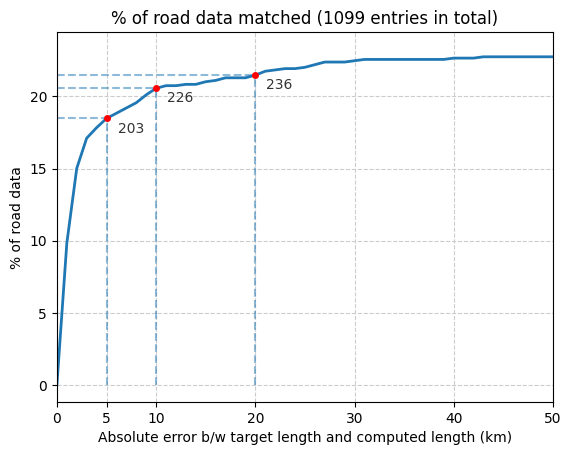

In [74]:
fig = plt.figure()
N = 1099
sorted_diffs = np.arange(100)
frac = np.array([(abs_diffs < d).sum() for d in sorted_diffs]) / N
pct = 100 * frac
x, y = sorted_diffs, pct
plt.plot(x, y, linewidth=2)

for d in [5, 10, 20]:
    first_line = LineString(np.column_stack((x, y)))
    second_line = LineString([(d, 0), (d, 100)])
    intersection = first_line.intersection(second_line)

    if intersection.geom_type == 'MultiPoint':
        intersection_x, intersection_y = np.array(LineString(intersection).xy)
    elif intersection.geom_type == 'Point':
        intersection_x, intersection_y = np.array(intersection.xy)

    plt.vlines(x=intersection_x, ymin=0, ymax=intersection_y, linestyle='--', alpha=0.5)
    plt.hlines(y=intersection_y, xmin=0, xmax=intersection_x, linestyle='--', alpha=0.5)
    plt.scatter(intersection_x, intersection_y, s=16, c='red', zorder=10)
#     plt.annotate(f'{int(intersection_y*N//100)} ({float(intersection_y):.2f} %)', 
    plt.annotate(f'{int(intersection_y*N//100)}', 
                 (intersection_x, intersection_y), 
                 (8, -10), 
                 textcoords='offset points',
                 alpha=0.8)

plt.xlim((0, 50))

# plt.yticks(np.arange(0, 1.1, .1))
locs, _ = plt.xticks()
locs = np.array(locs, dtype=int).tolist() + [i for i in [5, 10, 20] if i not in locs]
plt.xticks(locs, locs)

plt.ylabel('% of road data')
plt.xlabel('Absolute error b/w target length and computed length (km)')
plt.title(f'% of road data matched ({N} entries in total)')
plt.grid(color='#ccc', linestyle='--')
plt.show()

fig.savefig('diff-cdf.png', bbox_inches='tight', pad_inches=0.2)

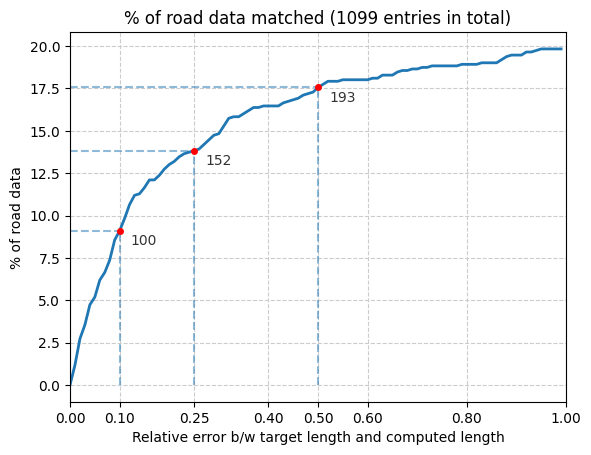

In [76]:
fig = plt.figure()
N = 1099
sorted_errs = np.arange(100) / 100
frac = np.array([(rel_errs < d).sum() for d in sorted_errs]) / N
pct = 100 * frac
x, y = sorted_errs, pct
plt.plot(x, y, linewidth=2)

for d in [.1, .25, .5]:
    first_line = LineString(np.column_stack((x, y)))
    second_line = LineString([(d, 0), (d, 100)])
    intersection = first_line.intersection(second_line)

    if intersection.geom_type == 'MultiPoint':
        intersection_x, intersection_y = np.array(LineString(intersection).xy)
    elif intersection.geom_type == 'Point':
        intersection_x, intersection_y = np.array(intersection.xy)

    plt.vlines(x=intersection_x, ymin=0, ymax=intersection_y, linestyle='--', alpha=0.5)
    plt.hlines(y=intersection_y, xmin=0, xmax=intersection_x, linestyle='--', alpha=0.5)
    plt.scatter(intersection_x, intersection_y, s=16, c='red', zorder=10)
    plt.annotate(f'{int(intersection_y*N//100)}', 
                 (intersection_x, intersection_y), 
                 (8, -10), 
                 textcoords='offset points',
                 alpha=0.8)

plt.xlim((0, 1))

# plt.yticks(np.arange(0, 1.1, .1))
locs, _ = plt.xticks()
locs = list(locs) + [i for i in [.1, .25, .5] if i not in locs]
locs.remove(.2)
plt.xticks(locs)

plt.ylabel('% of road data')
plt.xlabel('Relative error b/w target length and computed length')
plt.title(f'% of road data matched ({N} entries in total)')
plt.grid(color='#ccc', linestyle='--')
plt.show()

fig.savefig('err-cdf.png', bbox_inches='tight', pad_inches=0.2)

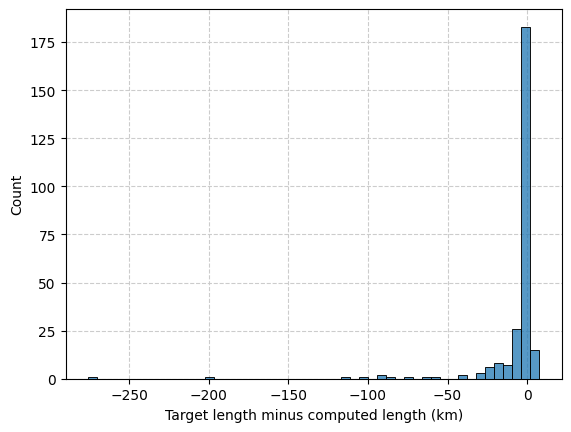

In [80]:
fig = plt.figure()
sns.histplot(diffs, bins=50, zorder=10)
plt.xlabel('Target length minus computed length (km)')
plt.ylabel('Count')
plt.grid(color='#ccc', linestyle='--')
plt.show()
fig.savefig('diff-hist.png', bbox_inches='tight', pad_inches=0.2)

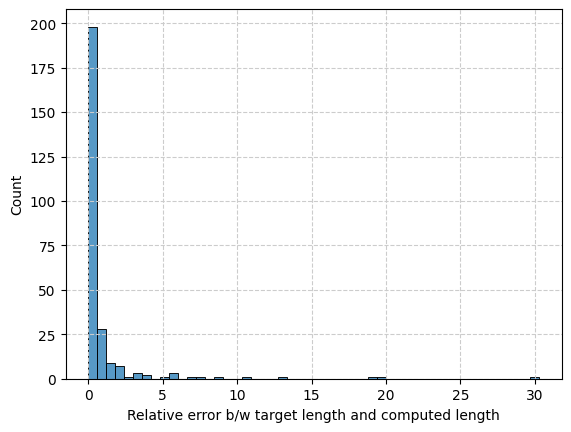

In [81]:
fig = plt.figure()
sns.histplot(rel_errs[rel_errs < np.inf], bins=50)
plt.xlabel('Relative error b/w target length and computed length')
plt.ylabel('Count')
plt.grid(color='#ccc', linestyle='--')
plt.show()
fig.savefig('err-hist.png', bbox_inches='tight', pad_inches=0.2)

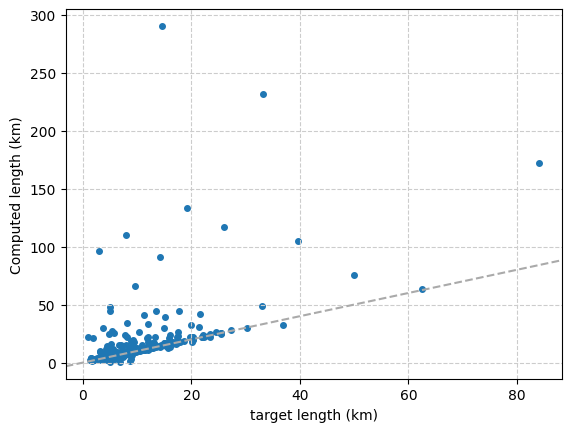

In [82]:
fig = plt.figure()
plt.grid(color='#ccc', linestyle='--')
ax = plt.gca()
ax.axline((1, 1), slope=1, alpha=1, color='#aaa', linestyle='--')
# sns.scatterplot(x=[m['wb_length'] for m in matches], y=[m['length'] for m in matches], s=16)
plt.scatter(x=[m['wb_length'] for m in matches], y=[m['length'] for m in matches], s=16)
plt.xlabel('target length (km)')
plt.ylabel('Computed length (km)')
plt.show()
fig.savefig('length-scatter.png', bbox_inches='tight', pad_inches=0.2)

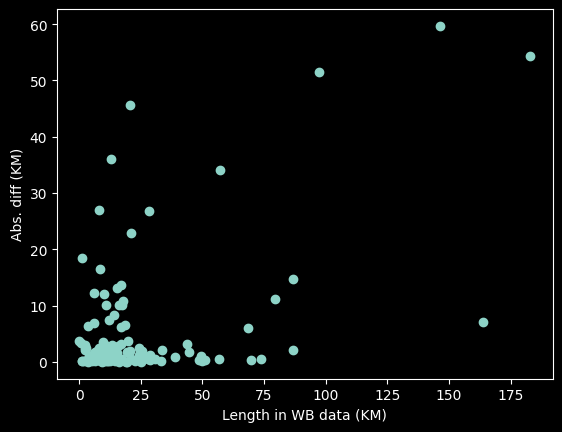

In [52]:
plt.scatter([m['wb_length'] for m in matches], [abs(m['diff']) for m in matches])
plt.xlabel('Length in WB data (KM)')
plt.ylabel('Abs. diff (KM)')
plt.show()

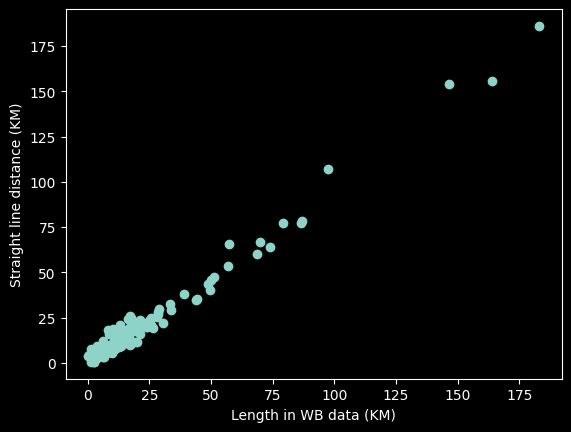

In [53]:
plt.scatter([m['wb_length'] for m in matches], [m['straight_line_dist'] for m in matches])
plt.xlabel('Length in WB data (KM)')
plt.ylabel('Straight line distance (KM)')
plt.show()

## Save matched routes

In [54]:
# with open('matches_20210610.pkl', 'wb') as f:
#     pickle.dump(matches, f)

In [48]:
matches_df = gpd.GeoDataFrame.from_records(matches)

In [17]:
def route_to_geom(G, route):
    nodes = G.nodes
    points = [nodes[k] for k in route]
    points = [Point(p['x'], p['y']) for p in points]
    geom = LineString(points)
    return geom

In [49]:
matches_df['geometry'] = [route_to_geom(G, r) for r in matches_df.route]

In [50]:
del matches_df['p1']
del matches_df['p2']
del matches_df['route']

In [ ]:
# matches_df = pd.merge(
#     matches_df, 
#     df[['id', 'description of the section', 'endpoint_1', 'endpoint_2', 'iri']], 
#     how='left', 
#     left_on=['p1_name', 'p2_name'], 
#     right_on=['endpoint_1', 'endpoint_2'])


In [39]:
matches_df.rename({'length': 'route_length'})

,p1_name,p2_name,wb_length,start_node,end_node,length,straight_line_dist,diff,abs_diff,rel_error,geometry
0,alto vera,karona,2.511536,1721615670,1721640796,0.455322,0.476338,2.056214,2.056214,0.818708,"LINESTRING (-55.76720 -26.75240, -55.76648 -26..."
1,alto vera,ynamb,10.679650,4961815462,4962604343,13.762351,12.425141,-3.082701,3.082701,0.288652,"LINESTRING (-55.74212 -26.59690, -55.74206 -26..."
2,altos,atyr,9.380511,4128334193,1762333956,8.816331,7.395640,0.564180,0.564180,0.060144,"LINESTRING (-57.15850 -25.19633, -57.15953 -25..."
3,aregua,isla vall,4.373238,859230941,2839928325,3.851713,5.292079,0.521525,0.521525,0.119254,"LINESTRING (-57.38485 -25.31236, -57.38407 -25..."
4,aregua,patin,6.555620,859230941,1763421574,6.422825,5.118316,0.132795,0.132795,0.020257,"LINESTRING (-57.38485 -25.31236, -57.38493 -25..."
...,...,...,...,...,...,...,...,...,...,...,...
126,ybyraty,pilar,86.702748,2387517709,2642192694,101.474464,78.184234,-14.771716,14.771716,0.170372,"LINESTRING (-57.62900 -26.71187, -57.62825 -26..."
127,ypacarai,caacupe,16.198263,5673585633,1761956483,15.763417,13.906454,0.434846,0.434846,0.026845,"LINESTRING (-57.26667 -25.38788, -57.26631 -25..."
128,ypacaray,pirayu,12.620605,2841236580,1761236189,11.566805,8.937517,1.053800,1.053800,0.083498,"LINESTRING (-57.28847 -25.40817, -57.28720 -25..."
129,ypane,desv guarambar,0.663527,6574911907,380642082,4.094248,4.051300,-3.430721,3.430721,5.170429,"LINESTRING (-57.48697 -25.46835, -57.48653 -25..."


In [45]:
df[df.columns.difference(['length'])]

,name,length,roughness,endpoint_1,endpoint_2
0,4 mojones - ytoror,0.712112,4.00,4 mojones,ytoror
1,acceso sur - villeta,9.290712,4.65,acceso sur,villeta
2,alto vera - karona,2.511536,5.00,alto vera,karona
3,alto vera - ynamb,10.679650,5.00,alto vera,ynamb
4,altos - atyr,9.380511,5.00,altos,atyr
...,...,...,...,...,...
164,ypacarai - caacupe,16.198263,3.80,ypacarai,caacupe
165,ypacaray - pirayu,12.620605,5.00,ypacaray,pirayu
166,ypane - desv guarambar,0.663527,5.00,ypane,desv guarambar
167,ytororo - cervepa,1.683191,4.00,ytororo,cervepa


In [51]:
matches_df = pd.merge(
    matches_df, 
    df[df.columns.difference(['length'])], 
    how='left', 
    left_on=['p1_name', 'p2_name'], 
    right_on=['endpoint_1', 'endpoint_2'])


In [52]:
matches_df

,p1_name,p2_name,wb_length,start_node,end_node,length,straight_line_dist,diff,abs_diff,rel_error,geometry,endpoint_1,endpoint_2,name,roughness
0,alto vera,karona,2.511536,1721615670,1721640796,0.455322,0.476338,2.056214,2.056214,0.818708,"LINESTRING (-55.76720 -26.75240, -55.76648 -26...",alto vera,karona,alto vera - karona,5.0
1,alto vera,ynamb,10.679650,4961815462,4962604343,13.762351,12.425141,-3.082701,3.082701,0.288652,"LINESTRING (-55.74212 -26.59690, -55.74206 -26...",alto vera,ynamb,alto vera - ynamb,5.0
2,altos,atyr,9.380511,4128334193,1762333956,8.816331,7.395640,0.564180,0.564180,0.060144,"LINESTRING (-57.15850 -25.19633, -57.15953 -25...",altos,atyr,altos - atyr,5.0
3,aregua,isla vall,4.373238,859230941,2839928325,3.851713,5.292079,0.521525,0.521525,0.119254,"LINESTRING (-57.38485 -25.31236, -57.38407 -25...",aregua,isla vall,aregua - isla vall,3.0
4,aregua,patin,6.555620,859230941,1763421574,6.422825,5.118316,0.132795,0.132795,0.020257,"LINESTRING (-57.38485 -25.31236, -57.38493 -25...",aregua,patin,aregua - patin,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,ybyraty,pilar,86.702748,2387517709,2642192694,101.474464,78.184234,-14.771716,14.771716,0.170372,"LINESTRING (-57.62900 -26.71187, -57.62825 -26...",ybyraty,pilar,ybyraty - pilar,1.9
127,ypacarai,caacupe,16.198263,5673585633,1761956483,15.763417,13.906454,0.434846,0.434846,0.026845,"LINESTRING (-57.26667 -25.38788, -57.26631 -25...",ypacarai,caacupe,ypacarai - caacupe,3.8
128,ypacaray,pirayu,12.620605,2841236580,1761236189,11.566805,8.937517,1.053800,1.053800,0.083498,"LINESTRING (-57.28847 -25.40817, -57.28720 -25...",ypacaray,pirayu,ypacaray - pirayu,5.0
129,ypane,desv guarambar,0.663527,6574911907,380642082,4.094248,4.051300,-3.430721,3.430721,5.170429,"LINESTRING (-57.48697 -25.46835, -57.48653 -25...",ypane,desv guarambar,ypane - desv guarambar,5.0


In [241]:
# matches_df.to_csv('matches_20210616.csv')

In [263]:
matches_df.to_file("gt_all_matches.gpkg", layer='guatemala_all_matches', driver="GPKG")
matches_df[matches_df.abs_diff <= 5].to_file("gt_good_matches.gpkg", layer='guatemala_good_matches', driver="GPKG")

In [53]:
matches_df.to_file("py_all_matches.gpkg", layer='paraguay_all_matches', driver="GPKG")
matches_df[matches_df.abs_diff <= 5].to_file("py_good_matches.gpkg", layer='paraguay_good_matches', driver="GPKG")

In [27]:
G.edges[(matches[0]['route'][0], matches[0]['route'][1])]

{'osmid': 160086696,
 'oneway': True,
 'lanes': '2',
 'highway': 'tertiary',
 'length': 135.638}

In [28]:
nodes, edges = ox.graph_to_gdfs(nx.MultiDiGraph(G))

In [32]:
# route = matches[0]['route']
# edge_infos = [
#     edges.loc[(u, v, 0)].to_dict()
#     for u, v in zip(route[:-1], route[1:])
# ]
pd.DataFrame.from_records(edge_infos)

,osmid,oneway,lanes,ref,name,highway,length,maxspeed,bridge,access,tunnel,junction,width,service,geometry
0,160086696,True,2,NaN,NaN,tertiary,135.638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-55.7672023 -26.752401, -55.766481..."
1,160086696,True,2,NaN,NaN,tertiary,105.317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-55.7664817 -26.7534373, -55.76593..."
2,160086696,True,2,NaN,NaN,tertiary,17.198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-55.7659381 -26.7542506, -55.76580..."
3,160090709,False,2,NaN,NaN,tertiary,45.646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-55.7658076 -26.7543523, -55.76555..."
4,160090709,False,2,NaN,NaN,tertiary,69.625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-55.7655525 -26.7546938, -55.76518..."
5,160090709,False,2,NaN,NaN,tertiary,2.845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-55.7651867 -26.755228, -55.765175..."
6,160090709,False,2,NaN,NaN,tertiary,79.053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-55.7651751 -26.7552514, -55.76476..."


In [59]:
def edges_to_geojson(edge_infos):
    features = []
    for info in edge_infos:
        f = {
            'type': 'Feature',
            'geometry': mapping(info['geometry']),
            'properties': {k: v for (k, v) in info.items() if k not in ['geometry']}
        }
        f['properties']['osmid'] = str(f['properties']['osmid'])
        f['properties']['oneway'] = str(f['properties']['oneway'])
        features.append(f)
    gjson = geojson.FeatureCollection(features)
    return gjson

In [82]:
root = './matched_routes_20210610'
os.makedirs(root, exist_ok=True)
wb_fields_to_include = ['roughness']

with tqdm(matches) as bar:
    for m in bar:
        if m['route'] is None:
            continue
        p1_name = m['p1_name']
        p2_name = m['p2_name']
        route = m['route']
        edge_infos = [
            edges.loc[(u, v, 0)].to_dict()
            for u, v in zip(route[:-1], route[1:])
        ]
        
        wb_data = df[(df.endpoint_1 == p1_name) & (df.endpoint_2 == p2_name)]
        wb_data = next(wb_data.itertuples(index=False))._asdict()
        wb_data = {k: wb_data[k] for k in wb_fields_to_include}
        for d in edge_infos:
            d.update(wb_data)

        gjson = edges_to_geojson(edge_infos)
        
        filename = f'{root}/{p1_name}--{p2_name} ({m["diff"]:.1f}, {m["rel_error"]:.1f}).json'
        bar.set_postfix({
            'filename': filename
        })
        with open(filename, 'w') as f:
            json.dump(gjson, f)


100%|██████████| 131/131 [00:09<00:00, 14.00it/s, filename=./matched_routes_20210610/ytororo--ypan (0.1, 0.0).json]                              
